# A high resolution model of the grapevine leaf morphospace predicts synthetic leaves
## Reanalysis with added data from Algeria germplasm

_______

# IMPORT MODULES

In [1]:
# import modules and functions

import matplotlib.pyplot as plt
from pylab import *
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d # for interpolating points
from scipy.signal import find_peaks # for peak detection
from sklearn.decomposition import PCA # for principal component analysis
from scipy.optimize import curve_fit # for fitting curves
from scipy.spatial import procrustes # for Procrustes analysis
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from scipy.spatial import ConvexHull # for convex hulls
from matplotlib.patches import Rectangle
from matplotlib.path import Path
from numpy.linalg import det # for sampling higher dimensional convex hull
from scipy.stats import dirichlet
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay


# DEFINE FUNCTIONS

In [2]:
# define functions

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 270 - degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def detect_landmark(vein,tip_indices,start_ind,end_ind,ref_ind,use_forward=True,use_max=True):
    """
    define a function to find index of farthest/closest point from ref index point for a set of vein coordinates
    inputs: 2D array of vein points, rows are points columns x and y coordinate values,
    indices of tips, start index, end index, reference idex
    if use_forward=True, then should be used on the forward side of the leaf, otherwise the reverse
    if use_max=True, then finds furthest point from ref, otherwise closest
    ouputs: index of the farthest/closest point from reference
    dependencies: uses the funciton euclid_dist
    """
    ref_dist = [] # store distances to end index 
    dist_ind = [] # store indices for each distance
    if use_forward==True:
        for i in range(start_ind+1, end_ind):
            ref_dist.append(euclid_dist(vein[ref_ind,0],vein[ref_ind,1],vein[i,0],vein[i,1]))
            dist_ind.append(i)
    else:
        for i in range(end_ind+1, start_ind):
            ref_dist.append(euclid_dist(vein[ref_ind,0],vein[ref_ind,1],vein[i,0],vein[i,1]))
            dist_ind.append(i)
    if use_max==True:  
        max_dist_ind = ref_dist.index(max(ref_dist))
        pt_ind = dist_ind[max_dist_ind]
    else:
        min_dist_ind = ref_dist.index(min(ref_dist))
        pt_ind = dist_ind[min_dist_ind]
    return pt_ind
    
def internal_landmarks(vein,tip_indices):
    """
    define a function to return indices of internal vein landmarks given vein tip indices
    inputs: 2D array of vein points, rows are points columns x and y coordinate values,
    indices of tips
    ouputs: a list of indices of internal vein landmarks
    dependencies: detect_landmark
    """
    ### FORWARD SIDE OF LEAF
    
    ### PROXIMAL LOBE
    ### POINT B, 1
    ptB_ind = detect_landmark(vein,tip_indices,tip_indices[1],tip_indices[2],tip_indices[2],use_forward=True,use_max=True)
    ### POINT A, 2
    ptA_ind = detect_landmark(vein,tip_indices,tip_indices[0],tip_indices[1],ptB_ind,use_forward=True,use_max=False)
    ### POINT D, 3
    ptD_ind = detect_landmark(vein,tip_indices,tip_indices[2],tip_indices[3],tip_indices[3],use_forward=True,use_max=True)
    ### POINT C, 4
    ptC_ind = detect_landmark(vein,tip_indices,tip_indices[1],tip_indices[2],ptD_ind,use_forward=True,use_max=False)
    ### POINT F, 5
    ptF_ind = detect_landmark(vein,tip_indices,tip_indices[3],tip_indices[4],tip_indices[4],use_forward=True,use_max=True)
    ### POINT E, 6
    ptE_ind = detect_landmark(vein,tip_indices,tip_indices[2],tip_indices[3],ptF_ind,use_forward=True,use_max=False)
    ### POINT G, 7
    ptG_ind = detect_landmark(vein,tip_indices,tip_indices[4],tip_indices[5],tip_indices[5],use_forward=True,use_max=True)

    ### DISTAL LOBE
    ### POINT I, 8
    ptI_ind = detect_landmark(vein,tip_indices,tip_indices[5],tip_indices[6],tip_indices[6],use_forward=True,use_max=True)
    ### POINT H, 9
    ptH_ind = detect_landmark(vein,tip_indices,tip_indices[4],tip_indices[5],ptI_ind,use_forward=True,use_max=False)
    ### POINT K, 10
    ptK_ind = detect_landmark(vein,tip_indices,tip_indices[6],tip_indices[7],tip_indices[7],use_forward=True,use_max=True)
    ### POINT J, 11
    ptJ_ind = detect_landmark(vein,tip_indices,tip_indices[5],tip_indices[6],ptK_ind,use_forward=True,use_max=False)
    ### POINT M, 12
    ptM_ind = detect_landmark(vein,tip_indices,tip_indices[7],tip_indices[8],tip_indices[8],use_forward=True,use_max=True)
    ### POINT L, 13
    ptL_ind = detect_landmark(vein,tip_indices,tip_indices[6],tip_indices[7],ptM_ind,use_forward=True,use_max=False)
    ### POINT N, 14
    ptN_ind = detect_landmark(vein,tip_indices,tip_indices[8],tip_indices[9],tip_indices[9],use_forward=True,use_max=True)
    
    ### MIDVEIN
    ### POINT P, 15
    ptP_ind = detect_landmark(vein,tip_indices,tip_indices[9],tip_indices[10],tip_indices[10],use_forward=True,use_max=True)
    ### POINT O, 16
    ptO_ind = detect_landmark(vein,tip_indices,tip_indices[8],tip_indices[9],ptP_ind,use_forward=True,use_max=False)
    ### POINT R, 17
    ptR_ind = detect_landmark(vein,tip_indices,tip_indices[10],tip_indices[11],tip_indices[11],use_forward=True,use_max=True)
    ### POINT Q, 18
    ptQ_ind = detect_landmark(vein,tip_indices,tip_indices[9],tip_indices[10],ptR_ind,use_forward=True,use_max=False)
    ### POINT T, 19
    ptT_ind = detect_landmark(vein,tip_indices,tip_indices[11],tip_indices[12],tip_indices[12],use_forward=True,use_max=True)
    ### POINT S, 20
    ptS_ind = detect_landmark(vein,tip_indices,tip_indices[10],tip_indices[11],ptT_ind,use_forward=True,use_max=False)

    ### REVERSE SIDE OF LEAF
    
    ### PROXIMAL LOBE
    ### POINT zB
    ptzB_ind = detect_landmark(vein,tip_indices,tip_indices[-2],tip_indices[-3],tip_indices[-3],use_forward=False,use_max=True)
    ### POINT zA
    ptzA_ind = detect_landmark(vein,tip_indices,tip_indices[-1],tip_indices[-2],ptzB_ind,use_forward=False,use_max=False)
    ### POINT zD
    ptzD_ind = detect_landmark(vein,tip_indices,tip_indices[-3],tip_indices[-4],tip_indices[-4],use_forward=False,use_max=True)
    ### POINT zC
    ptzC_ind = detect_landmark(vein,tip_indices,tip_indices[-2],tip_indices[-3],ptzD_ind,use_forward=False,use_max=False)
    ### POINT zF
    ptzF_ind = detect_landmark(vein,tip_indices,tip_indices[-4],tip_indices[-5],tip_indices[-5],use_forward=False,use_max=True)
    ### POINT zE
    ptzE_ind = detect_landmark(vein,tip_indices,tip_indices[-3],tip_indices[-4],ptzF_ind,use_forward=False,use_max=False)
    ### POINT zG
    ptzG_ind = detect_landmark(vein,tip_indices,tip_indices[-5],tip_indices[-6],tip_indices[-6],use_forward=False,use_max=True)

    ### DISTAL LOBE
    ### POINT zI
    ptzI_ind = detect_landmark(vein,tip_indices,tip_indices[-6],tip_indices[-7],tip_indices[-7],use_forward=False,use_max=True)
    ### POINT zH
    ptzH_ind = detect_landmark(vein,tip_indices,tip_indices[-5],tip_indices[-6],ptzI_ind,use_forward=False,use_max=False)
    ### POINT zK
    ptzK_ind = detect_landmark(vein,tip_indices,tip_indices[-7],tip_indices[-8],tip_indices[-8],use_forward=False,use_max=True)
    ### POINT zJ
    ptzJ_ind = detect_landmark(vein,tip_indices,tip_indices[-6],tip_indices[-7],ptzK_ind,use_forward=False,use_max=False)
    ### POINT zM
    ptzM_ind = detect_landmark(vein,tip_indices,tip_indices[-8],tip_indices[-9],tip_indices[-9],use_forward=False,use_max=True)
    ### POINT zL
    ptzL_ind = detect_landmark(vein,tip_indices,tip_indices[-7],tip_indices[-8],ptzM_ind,use_forward=False,use_max=False)
    ### POINT zN
    ptzN_ind = detect_landmark(vein,tip_indices,tip_indices[-9],tip_indices[-10],tip_indices[-10],use_forward=False,use_max=True)

    ### MIDVEIN
    ### POINT zP
    ptzP_ind = detect_landmark(vein,tip_indices,tip_indices[-10],tip_indices[-11],tip_indices[-11],use_forward=False,use_max=True)
    ### POINT zO
    ptzO_ind = detect_landmark(vein,tip_indices,tip_indices[-9],tip_indices[-10],ptzP_ind,use_forward=False,use_max=False)
    ### POINT zR
    ptzR_ind = detect_landmark(vein,tip_indices,tip_indices[-11],tip_indices[-12],tip_indices[-12],use_forward=False,use_max=True)
    ### POINT zQ
    ptzQ_ind = detect_landmark(vein,tip_indices,tip_indices[-10],tip_indices[-11],ptzR_ind,use_forward=False,use_max=False)
    ### POINT zT
    ptzT_ind = detect_landmark(vein,tip_indices,tip_indices[-12],tip_indices[-13],tip_indices[-13],use_forward=False,use_max=True)
    ### POINT zS
    ptzS_ind = detect_landmark(vein,tip_indices,tip_indices[-11],tip_indices[-12],ptzT_ind,use_forward=False,use_max=False)
    
    landmark_indices = [ptA_ind,ptB_ind,ptC_ind,ptD_ind,ptE_ind,ptF_ind,ptG_ind,ptH_ind,ptI_ind,ptJ_ind,
             ptK_ind,ptL_ind,ptM_ind,ptN_ind,ptO_ind,ptP_ind,ptQ_ind,ptR_ind,ptS_ind,ptT_ind,
             ptzT_ind,ptzS_ind,ptzR_ind,ptzQ_ind,ptzP_ind,ptzO_ind,ptzN_ind,ptzM_ind,ptzL_ind,ptzK_ind,
             ptzJ_ind,ptzI_ind,ptzH_ind,ptzG_ind,ptzF_ind,ptzE_ind,ptzD_ind,ptzC_ind,ptzB_ind,ptzA_ind
            ]
    
    return landmark_indices

def interpolated_intervals(land_indices, new_xvals, new_yvals, num_land):
    
    """
    define a function to return interpolated points for each interval between landmarks of a trace file
    inputs: landmark indices, xvals and yvals of polyline at desired resolution,
    number of interpolated landmarks per interval
    outputs: lists of x and y values with specified number of interpolated points per interval
    dependencies: interpolation
    """
    
    inter_points_x = [] # list to store interpolated x vals
    inter_points_y = [] # list to store interpolated y vals

    for i in range(len(land_indices)-1): # for each index, minus 1, because we are analyzing intervals

        beg_ind = land_indices[i] # specify the beginning point, based on index
        end_ind = land_indices[i+1] # specify the end point, based on index

        interval_xvals = new_xvals[beg_ind:end_ind] # using indices above, find the interval of x vals
        interval_yvals = new_yvals[beg_ind:end_ind] # using indices above, find the interval of y vals

        curr_inter_xvals, curr_inter_yvals = interpolation(interval_xvals, interval_yvals, num_land) # interpolate the interval

        curr_inter_xvals = list(curr_inter_xvals) # convert interval x vals into a list
        curr_inter_yvals = list(curr_inter_yvals) # convert interval y vals into a list

        # to prevent duplicated pseudo-landmark points, because we are working with intervals:

        if i==0: # if the first interval, delete the end point, because it will be covered in the next interval

            del curr_inter_xvals[-1]
            del curr_inter_yvals[-1]

        if i!=0: # if not the first interval, delete the start point, because it was covered in the previous interval

            del curr_inter_xvals[0]
            del curr_inter_yvals[0]

        for j in range(len(curr_inter_xvals)): # for the current interval points

            inter_points_x.append(curr_inter_xvals[j]) # append current interval x vals to list
            inter_points_y.append(curr_inter_yvals[j]) # append current interval y vals to list

    return inter_points_x, inter_points_y

def rotate_and_scale(vein_xvals, vein_yvals, blade_xvals, blade_yvals, base_ind, tip_ind, end_ind, px2_cm2):
    """
    define a function to rotate tip downwards, scale to centimeters, and translate petiolar junction to the origin
    inputs: interpolated x and y vein and blade values, base(first), tip, and end indices, and px2 to cm2 scale
    outputs: rotated, scaled, and translated landmark, vein, and blade coordinates
    dependencies: PCA from sklearn, rotate_points
    """
    vein_arr = np.column_stack((vein_xvals, vein_yvals)) # create vein coordinates array
    blade_arr = np.column_stack((blade_xvals, blade_yvals)) # create blade coordinates array

    vein_len = np.shape(vein_arr)[0] # get lengths of vein and blade arrays to retrieve coords later
    blade_len = np.shape(blade_arr)[0]
    overall_len = vein_len + blade_len

    overall_arr = np.row_stack((vein_arr, blade_arr)) # stack vein and blade arrays into single array

    px_cm = np.sqrt(px2_cm2) # take square root of scaling factor to scale pixels to cm
    scaled_arr = overall_arr/px_cm # convert pixels into cm
    tip_to_base_cm = np.sqrt((scaled_arr[tip_ind,0]-scaled_arr[base_ind,0])**2  # get distance in pixels from tip to base of leaf
                             + (scaled_arr[tip_ind,1]-scaled_arr[base_ind,1])**2) # use to scale PC values back to cm later
    
    # perform a principal component analysis on data to center
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(overall_arr)
    df = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    
    # find the angle of the leaf tip relative to the origin
    
    p1 = (df["pc1"].loc[tip_ind,], df["pc2"].loc[tip_ind,]) # get leaf tip PC1/PC2 coordinate value
    p2 = (0,0) # find angle relative to vertex at origin
    p3 = (10,0) # an arbitrary positive point along the x axis to find angle in anticlockwise direction

    angle = angle_between(p1, p2, p3) # find the angle in degrees of tip point relative to origin, anticlockwise

    rotated_xvals, rotated_yvals = rotate_points(df["pc1"], df["pc2"], angle)

    rotated_arr = np.column_stack((rotated_xvals, rotated_yvals)) # stack x and y vals back into one array

    tip_to_base_pca = np.sqrt((rotated_arr[tip_ind,0]-rotated_arr[base_ind,0])**2 # find the distance in PC vals between tip and base
                              + (rotated_arr[tip_ind,1]-rotated_arr[base_ind,1])**2)

    scale = tip_to_base_cm/tip_to_base_pca # find the factor to scale back to cm

    scaled_arr = rotated_arr*scale # scale rotated PC vals back to cm
    
    pet_junc = np.mean(scaled_arr[[base_ind,end_ind],:],axis=0)
    
    trans_x = scaled_arr[:,0] - pet_junc[0]
    trans_y = scaled_arr[:,1] - pet_junc[1]
    
    scaled_arr = np.column_stack((trans_x, trans_y))
    
    if scaled_arr[10,0] < 0: # insure left side of the leaf is left so labels are on right side of plot
        scaled_arr[:,0] = -scaled_arr[:,0]

    scaled_vein = scaled_arr[0:vein_len,] # isolate just vein coords
    scaled_blade = scaled_arr[vein_len:(vein_len+blade_len),] # isolate just blade coords

    return scaled_vein, scaled_blade # return scaled and rotated vein and blade

def PolyArea(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def calc_gpa_mean(shape_arr, num_pseuds, num_coords):
    """
    input: a 3D array of shapes, shapes x num_pseuds landmarks x num_coords coordinates
    output: a generalized Procrustes mean
    """
    
    shape_list = shape_arr # using an array instead of list, rename variable input
    
    ref_ind = 0 # select a reference index to calculate procrustes distances to
    ref_shape = shape_list[ref_ind] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(shape_list)),num_pseuds,num_coords) ) # empty 3D array: # samples, 21 landmarks, 2 coord vals

        for i in range(len(shape_list)): # for each leaf shape after removing outliers

            s1, s2, distance = procrustes(old_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    gpa_mean = new_mean
    
    return gpa_mean


# CREATE LIST OF LEAF IDENTIFIERS

For each leaf, starting on one side of the petiolar junction, in ImageJ/Fiji (Schindelin et al., 2012; Schneider et al., 2012) a trace of the vein and blade was made using the line segment tool and stored as a .txt file. An information file, storing species/variety name, the dataset the leaf scan originated from, the vine, developmental stage, file name of the associated image, dataset source, and scaling information, was stored as a .csv file. All three files have a three digit identifier indicating if they are from the Wolfskill/Geneva dataset (starting with "0") or the UC Davis vineyard dataset traced by MSU (starting with "1") or UC Davis (starting with "2) students seprated by underscore and followed by the species/variety name in capital letters. Another underscore separates an identifier indicating if the file is a blade or vein trace or information file ("blade", "vein", and "info", respectively). File names from a data folder were read in and used to store raw data and assocaited labels using the file names.

In [3]:
data_dir = "./data" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

duplicate_leaf_list = [] # store leaf identifiers, they will be duplicated
for i in range(len(file_names)): # for each file
    last_us = file_names[i].rindex("_") # get the last underscore position
    leaf_name = file_names[i][:last_us] # get the leaf identifier
    duplicate_leaf_list.append(leaf_name) # store leaf ID in duplicate_leaf_list
    
leaf_list = [] # a non-duplicated list of leaf identifiers
for i in duplicate_leaf_list: # for each leaf ID in the duplicated list
    if i not in leaf_list: # if it is not already in the unique list
        leaf_list.append(i) # append to the unique list
        
label_list = [] # create a label_list of leaf classes

for i in range(len(leaf_list)):

    leaf_name = leaf_list[i] # get the current leaf name

    first_us = file_names[i].index("_") # get the first underscore position
    leaf_ID = leaf_name[:first_us] # get just the 3 numeral ID of the leaf name
    leaf_num = int(leaf_ID) # convert the leaf_ID into an int
    first_num = leaf_ID[0] # get first number (string) of leaf_ID

    # IDENTIFY ORIGINAL VINIFERA AND WILD LEAVES
    if first_num=="0" and leaf_num==0:
        if leaf_name[4]!="V":
            label_list.append("vinifera")
        elif leaf_name[4]=="V":
            label_list.append("wild")
            
    # IDENTIFY ORIGINAL LEAVES HIGH ERROR 
    elif first_num=="0" and (leaf_num>0 and leaf_num<=17):
        label_list.append("error")
        
    # IDENTIFY ORIGINAL LEAVES USED FOR DEVELOPMENTAL SERIES
    elif first_num=="0" and (leaf_num>=18 and leaf_num<=57):
        if "leaf1" in leaf_name:
            label_list.append("leaf1")
        elif "leaf2" in leaf_name:
            label_list.append("leaf2")
        elif "leaf3" in leaf_name:
            label_list.append("leaf3")
        elif "leaf4" in leaf_name:
            label_list.append("leaf4")
    
    # IDENTIFY MICHIGAN STATE UNIVERSITY LEAVES
    elif first_num=="1":
        label_list.append("MSU")
    
    # IDENTIFY UNIVERSITY OF CALIFORNIA DAVIS LEAVES
    elif first_num=="2":
        label_list.append("UC Davis")

    # IDENTIFY ALGERIA LEAVES
    elif first_num=="3":
        label_list.append("Algeria")

            
    else:
        label_list.append("NA")



# print out leaf and label lists to check
for i in range(len(leaf_list)):
    print(label_list[i], leaf_list[i])
    

vinifera 000_ALICANTEBOUSCHET
vinifera 000_CABERNETSAUVIGNON
vinifera 000_CHARDONNAY
vinifera 000_CHASSELASCIOUTAT
vinifera 000_CHASSELASDORE
vinifera 000_FLAMETOKAY
vinifera 000_GEWURTZTRAMINER
vinifera 000_PINOTNOIR
vinifera 000_SYLVANER
vinifera 000_SYRAH
wild 000_VITISACERIFOLIA
wild 000_VITISAESTIVALIS
wild 000_VITISAMURENSIS
wild 000_VITISCINEREA
wild 000_VITISCOIGNETIAE
wild 000_VITISLABRUSCA
wild 000_VITISPALMATA
wild 000_VITISPIASEZKII
wild 000_VITISRIPARIA
wild 000_VITISRUPESTRIS
wild 000_VITISTHUNBERGII
wild 000_VITISVULPINA
vinifera 000_WHITERIESLING
vinifera 000_ZINFANDEL
error 001_leaf4_588147a
error 002_leaf1_wGVIT1627a
error 003_leaf5_588147a
error 004_leafb_K1164A
error 005_leafc_K1163A
error 006_leaf2_483180a
error 007_leaf8_w588055a
error 008_leaf2_wGVIT1626a
error 009_leaf10_wGVIT1626b
error 010_leaf2_483186a
error 011_leaf11_597257a
error 012_leafd_K1163A
error 013_leaf6_wGVIT1627a
error 014_leaf3_588538a
error 015_leaf1_279897a
error 016_leaf9_588174a
error 017_le

# FIND LANDMARKS

90 landmarks (25 from the vein tips, 40 internal vein landmarks, and 25 blade landmarks) were automatically detected from the vein and blade trace files. Vein and blade traces were interpolated with 1000 equidistantly spaced points to increase the resolution of the data using the interp1d function SciPy (Virtanen et al., 2020). The petiolar junction was calculated as the mean of the first ("a) and last ("y") coordinate in the vein trace file. The Euclidean distance of each vein trace point to the petiolar junction was calculated as a function of geodesic distance along the trace itself (or the index of each point, as points are equidistantly placed along the trace). The SciPy find_peaks function was used to find the 25 vein tip indices in the trace using the above plot. The 25 blade landmarks correspond closely to the 25 vein tip landmarks, and are identified by index as the closest point in the interpolated blade trace to an identified vein tip landmark using Euclidean distance. The 25 vein tip landmarks are labeled "a" through "y" in Figure 1A.

40 internal landmarks, placed on each side of the base of a vein, were calculated in the order indicated on Figure 1A. The landmark on the more distal side (farthest away from the petiolar junction) of the base of a vein was calculated before the proximal side (closer to the petiolar junction). The first calculated internal landmark of the base of a vein was used in reference to calculate the other. Internal landmarks were calculated by specifying a start and end index along a segment of the vein trace and a reference index. Calculating the Euclidean distance for each point along the segment from start to end to the reference index, the index with either a maximum or minimum distance value was assigned as the landmark. For example, internal landmark "1" was calculated using landmark "b" as the start index, landmark "c" as the end index, and landmark "c" as the reference index. Internal landmark "1 was calculated as the index with the maximum Euclidean distance along this segment from landmark "c". Landmark 2 was calculated using landmark "a" as the start index, landmark "b" as the end index, and internal landmark "1" as the reference index. Internal landmark "2" was calculated as the index with the minimum Euclideaa distance along this segment from landmark "1". The rest of the internal landmarks were calculated in a similar way, specifying the segment of the trace using previously calculated landmarks on which they fall, and calculating the minimum or maximum Euclidean distance from a reference landmark.

In [4]:
res = 1000 # set interpolated resolution
dist = 5 # minimum distance between peaks, MODIFY THIS IF YOU ARE HAVING TROUBLE IDENTIFYING VEIN TIPS

tip_indices = [] # tip indices, 25 pts

# NOTE: internal landmark points rely on accurately detecting vein tip indices
land_indices = [] # internal landmarks, 40 pts

# NOTE: blade landmark points rely on accurately detecting vein tip indices
blade_indices = [] # blade indices, 25 pts

for i in range(len(leaf_list)): # for the number of leaves
    
    ### get vein data
    curr_leaf = leaf_list[i] # select current leaf
    print(i,curr_leaf) # PRINT IN CASE OF ERROR TO GO BACK TO PROBLEM LEAVES
    vein = np.loadtxt("./data/" + curr_leaf + "_veins.txt") # load vein trace outline
    inter_vein_x, inter_vein_y = interpolation(vein[:,0],vein[:,1],res) # create interpolated vein outline
    origin = np.mean((vein[0],vein[-1]), axis=0) # find petiolar junction/origin
    
    ### find tip landmarks
    dist_ori = [] # store distance of each interpolated point to the petiolar junction/origin
    for j in range(res): # for the number of interpolated points
        dist_ori.append( euclid_dist(origin[0],origin[1],inter_vein_x[j],inter_vein_y[j]) )
    peaks, _ = find_peaks(dist_ori , height=0, distance=dist) # find peaks/vein tips
    peaks = np.insert(peaks,0,0)
    peaks = np.append(peaks, res-1)
    tip_indices.append(peaks) # save peak indices
    
    ### find internal landmarks
    inter_vein = np.column_stack((inter_vein_x, inter_vein_y))
    landmark_indices = internal_landmarks(inter_vein,peaks)
    land_indices.append(landmark_indices)
    
    ### get blade data
    blade = np.loadtxt("./data/" + curr_leaf + "_blade.txt") # load blade trace outline
    inter_blade_x, inter_blade_y = interpolation(blade[:,0],blade[:,1],res) # create interpolated blade outline
    
    ### find blade landmarks
    blade_pts = [] # to store blade index points
    for k in range(len(peaks)): # for each tip landmark, find closest blade index
        blade_dists = [] # empty list to store distances
        for l in range(res): # for each blade point
            blade_dists.append(euclid_dist(inter_vein_x[peaks[k]],inter_vein_y[peaks[k]],inter_blade_x[l],inter_blade_y[l]))
        blade_pts.append(blade_dists.index(min(blade_dists)))
    blade_indices.append(blade_pts)


0 000_ALICANTEBOUSCHET
1 000_CABERNETSAUVIGNON
2 000_CHARDONNAY
3 000_CHASSELASCIOUTAT
4 000_CHASSELASDORE
5 000_FLAMETOKAY
6 000_GEWURTZTRAMINER
7 000_PINOTNOIR
8 000_SYLVANER
9 000_SYRAH
10 000_VITISACERIFOLIA
11 000_VITISAESTIVALIS
12 000_VITISAMURENSIS
13 000_VITISCINEREA
14 000_VITISCOIGNETIAE
15 000_VITISLABRUSCA
16 000_VITISPALMATA
17 000_VITISPIASEZKII
18 000_VITISRIPARIA
19 000_VITISRUPESTRIS
20 000_VITISTHUNBERGII
21 000_VITISVULPINA
22 000_WHITERIESLING
23 000_ZINFANDEL
24 001_leaf4_588147a
25 002_leaf1_wGVIT1627a
26 003_leaf5_588147a
27 004_leafb_K1164A
28 005_leafc_K1163A
29 006_leaf2_483180a
30 007_leaf8_w588055a
31 008_leaf2_wGVIT1626a
32 009_leaf10_wGVIT1626b
33 010_leaf2_483186a
34 011_leaf11_597257a
35 012_leafd_K1163A
36 013_leaf6_wGVIT1627a
37 014_leaf3_588538a
38 015_leaf1_279897a
39 016_leaf9_588174a
40 017_leaf9_wGVIT1627a
41 018_leaf1_588154a
42 019_leaf2_588154a
43 020_leaf3_588154a
44 021_leaf4_588154a
45 022_leaf1_588174a
46 023_leaf2_588174a
47 024_leaf3_588

# CALCULATE PSEUDOLANDMARKS

Along each line segment of the vein trace defined by internal and tip landmarks, and each line segment of the blade trace defined by blade landmarks, 20 equidistant pseudo-landmarks were calculated. Redundant landmarks at the beginning and end of each segment were eliminated. There were 1672 pseudolandmarks total: 1216 vein and 456 blade.

In [5]:
# make a list of indices of leaves causing errors
error_indices = [ 35,  # 35 012_leafd_K1163A
                  94,  # 94 112_VITISACERIFOLIA
                  99,  # 99 117_GRN3
                  102, # 102 201_MALVASIABIANCA
                  105, # 'TREBBIANO', this leaf has a duplicate
                  120, # 120 219_DOGRIDGE
                  129, # 129 228_BARBERA
                  139, # 139 238_ALICANTEBOUSCHET
                  140, # 140 239_MARSANNE
                  141, # 141 240_RIPARIAGLOIRE
                  142, # 142 241_RIPARIAGLOIRE
                  145, # 145 244_CILIEGIOLO
                  146, # 146 245_CILIEGIOLO
                  152, # 152 300_AHMEUR BOU AHMEUR_ID01
                  154, #302_AHMEUR BOU AHMEUR_ID03
                  158, #306_AHMEUR BOU AHMEUR_ID07
                  160, #308_AHMEUR BOU AHMEUR_ID09
                  166, #314_BABARI_ID15
                  169, #317_BABARI_ID18
                  181, #329_GENOTYPE 1_ID30
                  189, #337_GENOTYPE 2_ID38
                  190, #338_GENOTYPE 2_ID39
                  196, #344_GENOTYPE 3_ID45 
                  198, #346_GENOTYPE 3_ID47
                  202, #350_GENOTYPE 3_ID51
                  212, #360_GENOTYPE 4_ID61
                  217, #365_GENOTYPE 4_ID66
                  235, #383_TIZI OUININE_ID84
                  237, #385_TIZI OUININE_ID86
                  239, #387_TIZI OUININE_ID88
                ]

print("Out of", len(leaf_list), "original leaves", len(leaf_list)-len(error_indices), "were used")

Out of 240 original leaves 210 were used


In [6]:
num_land = 20 # number of pseudolandmarks to interpolate each line segment
# res is defined above

scaled_vein_list = [] # store final vein pseudolandmarks
scaled_blade_list = [] # store final blade pseudolandmarks
index_list = [] # save indices without error leaves
species_list = [] # save species names for plotting
node_list = [] # save nodes for plotting

for i in range(len(leaf_list)): # for each leaf
    
    curr_leaf = leaf_list[i] # get current leaf
    print(i, curr_leaf)
    if i in error_indices: # skip this leaf if causing errors
        continue

    # read in data from ./data folder
    vein_trace = np.loadtxt("./data/" + curr_leaf + "_veins.txt") # vein trace outline
    inter_vein_x, inter_vein_y = interpolation(vein_trace[:,0],vein_trace[:,1],res) # create high res vein outline
    
    blade_trace = np.loadtxt("./data/" + curr_leaf + "_blade.txt") # blade trace outline
    inter_blade_x, inter_blade_y = interpolation(blade_trace[:,0],blade_trace[:,1],res) # create high res vein outline
    
    info_df = pd.read_csv("./data/" + curr_leaf + "_info.csv") # read in metadata

    # unpack metadata

    if label_list[i]=="Algeria": # if current leaf is Algeria
        species = curr_leaf[:-5] # then use the current leaf name for species
        species_list.append(species)
        node_list.append(leaf)

    else:
        species = info_df.iloc[0,1] 
        species_list.append(species)
        dataset = info_df.iloc[1,1]
        vine = info_df.iloc[2,1]
        leaf = info_df.iloc[3,1]
        node_list.append(leaf)
        image = info_df.iloc[4,1]
        source = info_df.iloc[5,1]
        px2_cm2 = float(info_df.iloc[6,1])
    
    # retrieve landmark data
    
    curr_tip_ind = tip_indices[i] # get tip indices of current leaf
    curr_int_ind = land_indices[i] # get internal indices of current leaf
    curr_bla_ind = blade_indices[i] # get blade indices of current leaf
    
    curr_vei_ind = [ # combine internal and tip indices into vein indices
        
                    curr_tip_ind[0], # beginning petiolar base
        
                    # left proximal lobe
                    curr_int_ind[0],
                    curr_tip_ind[1], # 1st proximal tip
                    
                    curr_int_ind[1],
                    curr_int_ind[2],
                    curr_tip_ind[2], # 2nd proximal tip
                    
                    curr_int_ind[3],
                    curr_int_ind[4],
                    curr_tip_ind[3], # 3rd proximal tip
        
                    curr_int_ind[5],
                    curr_tip_ind[4], # PROXIMAL TIP
        
                    # left distal lobe
                    curr_int_ind[6],
                    curr_int_ind[7],
                    curr_tip_ind[5], # 1st distal tip
                    
                    curr_int_ind[8],
                    curr_int_ind[9],
                    curr_tip_ind[6], # 2nd distal tip
                    
                    curr_int_ind[10],
                    curr_int_ind[11],
                    curr_tip_ind[7], # 3rd distal tip
        
                    curr_int_ind[12],
                    curr_tip_ind[8], # DISTAL TIP
        
                    # left midvein
                    curr_int_ind[13],
                    curr_int_ind[14],
                    curr_tip_ind[9], # 1st midvein tip
                    
                    curr_int_ind[15],
                    curr_int_ind[16],
                    curr_tip_ind[10], # 2nd midvein tip
                    
                    curr_int_ind[17],
                    curr_int_ind[18],
                    curr_tip_ind[11], # 3rd midvein tip
        
                    curr_int_ind[19],
                    curr_tip_ind[12], # MIDVEIN TIP
        
                    # right midvein
                    curr_int_ind[20],
                    curr_tip_ind[13], # 3rd midvein tip
        
                    curr_int_ind[21],
                    curr_int_ind[22],
                    curr_tip_ind[14], # 2nd midvein tip
        
                    curr_int_ind[23],
                    curr_int_ind[24],
                    curr_tip_ind[15], # 1st midvein tip
        
                    curr_int_ind[25],
                    curr_int_ind[26],
        
                    # right distal lobe
                    curr_tip_ind[16], # DISTAL TIP
        
                    curr_int_ind[27],
                    curr_tip_ind[17], # 3rd distal tip
        
                    curr_int_ind[28],
                    curr_int_ind[29],
                    curr_tip_ind[18], # 2nd distal tip
        
                    curr_int_ind[30],
                    curr_int_ind[31],
                    curr_tip_ind[19], # 1st distal tip
        
                    curr_int_ind[32],
                    curr_int_ind[33],
        
                    # right proximal lobe
                    curr_tip_ind[20], # PROXIMAL TIP
        
                    curr_int_ind[34],
                    curr_tip_ind[21], # 3rd proximal tip
        
                    curr_int_ind[35],
                    curr_int_ind[36],
                    curr_tip_ind[22], # 2nd proximal tip
        
                    curr_int_ind[37],
                    curr_int_ind[38],
                    curr_tip_ind[23], # 1st proximal tip
        
                    curr_int_ind[39],
        
                    curr_tip_ind[24] # ending petiolar base
                    ]
    
    vein_pseudx, vein_psuedy = interpolated_intervals(curr_vei_ind, inter_vein_x, inter_vein_y, num_land)
    blade_pseudx, blade_psuedy = interpolated_intervals(curr_bla_ind, inter_blade_x, inter_blade_y, num_land)
    
    scaled_vein, scaled_blade = rotate_and_scale(vein_pseudx, vein_psuedy, 
                                                 blade_pseudx, blade_psuedy, 
                                                 base_ind=0, 
                                                 tip_ind=int(1216/2), 
                                                 end_ind=int(len(vein_pseudx)+len(blade_pseudx))-1, 
                                                 px2_cm2=px2_cm2)
    
    scaled_vein_list.append(scaled_vein)
    scaled_blade_list.append(scaled_blade)
    index_list.append(i)


0 000_ALICANTEBOUSCHET
1 000_CABERNETSAUVIGNON
2 000_CHARDONNAY
3 000_CHASSELASCIOUTAT
4 000_CHASSELASDORE
5 000_FLAMETOKAY
6 000_GEWURTZTRAMINER
7 000_PINOTNOIR
8 000_SYLVANER
9 000_SYRAH
10 000_VITISACERIFOLIA
11 000_VITISAESTIVALIS
12 000_VITISAMURENSIS
13 000_VITISCINEREA
14 000_VITISCOIGNETIAE
15 000_VITISLABRUSCA
16 000_VITISPALMATA
17 000_VITISPIASEZKII
18 000_VITISRIPARIA
19 000_VITISRUPESTRIS
20 000_VITISTHUNBERGII
21 000_VITISVULPINA
22 000_WHITERIESLING
23 000_ZINFANDEL
24 001_leaf4_588147a
25 002_leaf1_wGVIT1627a
26 003_leaf5_588147a
27 004_leafb_K1164A
28 005_leafc_K1163A
29 006_leaf2_483180a
30 007_leaf8_w588055a
31 008_leaf2_wGVIT1626a
32 009_leaf10_wGVIT1626b
33 010_leaf2_483186a
34 011_leaf11_597257a
35 012_leafd_K1163A
36 013_leaf6_wGVIT1627a
37 014_leaf3_588538a
38 015_leaf1_279897a
39 016_leaf9_588174a
40 017_leaf9_wGVIT1627a
41 018_leaf1_588154a
42 019_leaf2_588154a
43 020_leaf3_588154a
44 021_leaf4_588154a
45 022_leaf1_588174a


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = di

46 023_leaf2_588174a
47 024_leaf3_588174a
48 025_leaf4_588174a
49 026_leaf1_313922a
50 027_leaf2_313922a
51 028_leaf3_313922a
52 029_leaf4_313922a
53 030_leaf1_483146a
54 031_leaf2_483146a
55 032_leaf3_483146a
56 033_leaf4_483146a
57 034_leaf1_588393a
58 035_leaf2_588393a
59 036_leaf3_588393a
60 037_leaf4_588393a
61 038_leaf1_588631a
62 039_leaf2_588631a
63 040_leaf3_588631a
64 041_leaf4_588631a
65 042_leaf1_483187a
66 043_leaf2_483187a
67 044_leaf3_483187a
68 045_leaf4_483187a
69 046_leaf1_483138a
70 047_leaf2_483138a
71 048_leaf3_483138a
72 049_leaf4_483138a
73 050_leaf1_w588451a
74 051_leaf2_w588451a
75 052_leaf3_w588451a
76 053_leaf4_w588451a
77 054_leaf1_588233a
78 055_leaf2_588233a
79 056_leaf3_588233a
80 057_leaf4_588233a
81 100_VITISROMANETII
82 101_VITISDOANIANA
83 101_VITISROMANETII
84 102_VITISDOANIANA
85 103_5C
86 104_5C
87 105_DOGRIDGE
88 106_DOGRIDGE
89 107_CORVINAVERONSE
90 108_CORVINAVERONSE
91 109_AXR1
92 110_AXR1
93 111_VITISACERIFOLIA
94 112_VITISACERIFOLIA
95 113_O3

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]
/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]


187 335_GENOTYPE 2_ID36
188 336_GENOTYPE 2_ID37
189 337_GENOTYPE 2_ID38
190 338_GENOTYPE 2_ID39
191 339_GENOTYPE 2_ID40
192 340_GENOTYPE 2_ID41
193 341_GENOTYPE 2_ID42
194 342_GENOTYPE 2_ID43
195 343_GENOTYPE 2_ID44
196 344_GENOTYPE 3_ID45
197 345_GENOTYPE 3_ID46
198 346_GENOTYPE 3_ID47
199 347_GENOTYPE 3_ID48
200 348_GENOTYPE 3_ID49
201 349_GENOTYPE 3_ID50
202 350_GENOTYPE 3_ID51
203 351_GENOTYPE 3_ID52
204 352_GENOTYPE 3_ID53
205 353_GENOTYPE 3_ID54
206 354_GENOTYPE 3_ID55
207 355_GENOTYPE 4_ID56
208 356_GENOTYPE 4_ID57
209 357_GENOTYPE 4_ID58
210 358_GENOTYPE 4_ID59
211 359_GENOTYPE 4_ID60
212 360_GENOTYPE 4_ID61
213 361_GENOTYPE 4_ID62
214 362_GENOTYPE 4_ID63
215 363_GENOTYPE 4_ID64
216 364_GENOTYPE 4_ID65
217 365_GENOTYPE 4_ID66
218 366_LOUALI_ID67
219 367_LOUALI_ID68
220 368_LOUALI_ID69
221 369_LOUALI_ID70
222 370_LOUALI_ID71
223 371_LOUALI_ID72
224 372_LOUALI_ID73
225 373_LOUALI_ID74
226 374_LOUALI_ID75
227 375_LOUALI_ID76
228 376_LOUALI_ID77
229 377_TIZI OUININE_ID78
230 378_TI

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/4082557163.py:37: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]


# ALGERIA PROCRUSTES ANALYSIS

The mean Procrustes distance of each leaf to every other leaf was calculated using the procrustes function from SciPy and plotted as a histogram by class. The Generalized Procrustes Analysis mean leaf was calculated by selecting an arbitrary reference leaf as the mean, superimposing all leaves to the reference and calculating a new mean, and continuing the cycle until the difference between two means from two successive iterations fell below an arbitrarily small value (Gower, 1975). For superimposed Procrustes coordinates, leaves were aligned with the calculated Generalized Procrustes Analysis mean leaf.

## Retrieve just Algeria data

In [22]:
algeria_vein_list = []
algeria_blade_list = []
algeria_name_list = []
algeria_original_names = []
for i in range(len(scaled_vein_list)):
    if label_list[index_list[i]]=="Algeria":
        algeria_vein_list.append(scaled_vein_list[i])
        algeria_blade_list.append(scaled_blade_list[i])
        name = species_list[i]
        if "AHMEUR BOU AHMEUR" in name:
            algeria_name_list.append("AHMEUR BOU AHMEUR")
            algeria_original_names.append(name)
        elif "BABARI" in name:
            algeria_name_list.append("BABARI")
            algeria_original_names.append(name)
        elif "GENOTYPE 1" in name:
            algeria_name_list.append("ICHMOUL")
            algeria_original_names.append(name)
        elif "GENOTYPE 2" in name:
            algeria_name_list.append("ICHMOUL BACHA")
            algeria_original_names.append(name)
        elif "GENOTYPE 3" in name:
            algeria_name_list.append("BOUABANE DES AURES")
            algeria_original_names.append(name)
        elif "GENOTYPE 4" in name:
            algeria_name_list.append("AMER BOUAMAR")
            algeria_original_names.append(name)
        elif "LOUALI" in name:
            algeria_name_list.append("LOUALI")
            algeria_original_names.append(name)
        elif "TIZI OUININE" in name:
            algeria_name_list.append("TIZI OUININE")
            algeria_original_names.append(name)
    

In [8]:
# create shape array

num_samples = len(algeria_vein_list)
num_vein_coords = np.shape(algeria_vein_list)[1]
num_blade_coords = np.shape(algeria_blade_list)[1]
num_pseuds = num_vein_coords + num_blade_coords
num_coords = 2

shape_arr = np.zeros((num_samples, num_pseuds, num_coords))

for i in range(len(algeria_vein_list)):
    
    shape_arr[i] = np.row_stack((algeria_vein_list[i], algeria_blade_list[i]))

np.shape(shape_arr)

(71, 1672, 2)

In [9]:
print("NUMBER OF VEIN COORDS", num_vein_coords)
print("NUMBER OF BLADE COORDS", num_blade_coords)

NUMBER OF VEIN COORDS 1216
NUMBER OF BLADE COORDS 456


In [10]:
1216+456

1672

In [11]:
# calculate GPA mean

gpa_mean = calc_gpa_mean(shape_arr, num_pseuds, num_coords)


In [12]:
# calculate indices of landmark points
# provide colors for fill

######################
# Individual indices #
######################

peta = 0

lp1a = 18
lp1t = lp1a+19
lp1b = lp1t+20

lp2a = lp1b+18
lp2t = lp2a+19
lp2b = lp2t+20

lp3a = lp2b+18
lp3t = lp3a+19
lp3b = lp3t+20

lptip = lp3b+18

###############

ldst = lptip+20

ld1a = ldst+18
ld1t = ld1a+19
ld1b = ld1t+20

ld2a = ld1b+18
ld2t = ld2a+19
ld2b = ld2t+20

ld3a = ld2b+18
ld3t = ld3a+19
ld3b = ld3t+20

ldtip = ld3b+18

###############

lmst = ldtip+20

lm1a = lmst+18
lm1t = lm1a+19
lm1b = lm1t+20

lm2a = lm1b+18
lm2t = lm2a+19
lm2b = lm2t+20

lm3a = lm2b+18
lm3t = lm3a+19
lm3b = lm3t+20

###############
mtip = lm3b+18
###############

rm3b = mtip+19
rm3t = rm3b+20
rm3a = rm3t+19

rm2b = rm3a+18
rm2t = rm2b+20
rm2a = rm2t+19

rm1b = rm2a+18
rm1t = rm1b+20
rm1a = rm1t+19

rmst = rm1a+18

###############

rdtip = rmst+20

rd3b = rdtip+18
rd3t = rd3b+20
rd3a = rd3t+19

rd2b = rd3a+18
rd2t = rd2b+20
rd2a = rd2t+19

rd1b = rd2a+18
rd1t = rd1b+20
rd1a = rd1t+19

rdst = rd1a+18

###############

rptip = rdst+20

rp3b = rptip+18
rp3t = rp3b+20
rp3a = rp3t+19

rp2b = rp3a+18
rp2t = rp2b+20
rp2a = rp2t+19

rp1b = rp2a+18
rp1t = rp1b+20
rp1a = rp1t+19

rpst = rp1a+18

####################
# Indices for fill #
####################

vein_indices = [
    peta, lp1a, lp1t, lp1b, lp2a, lp2t, lp2b, lp3a, lp3t, lp3b, lptip,
    ldst, ld1a, ld1t, ld1b, ld2a, ld2t, ld2b, ld3a, ld3t, ld3b, ldtip,
    lmst, lm1a, lm1t, lm1b, lm2a, lm2t, lm2b, lm3a, lm3t, lm3b, 
    mtip,
    rm3b, rm3t, rm3a, rm2b, rm2t, rm2a, rm1b, rm1t, rm1a, rmst,
    rdtip, rd3b, rd3t, rd3a, rd2b, rd2t, rd2a, rd1b, rd1t, rd1a, rdst,
    rptip, rp3b, rp3t, rp3a, rp2b, rp2t, rp2a, rp1b, rp1t, rp1a, rpst,
    ]

lp1_indices = list(range(lp1a,lp1b+1))
lp2_indices = list(range(lp2a,lp2b+1))
lp3_indices = list(range(lp3a,lp3b+1))
lprox_indices = list(range(peta,lp1a+1))+list(range(lp1b,lp2a+1))+list(range(lp2b,lp3a+1))+list(range(lp3b,ldst+1))

ld1_indices = list(range(ld1a,ld1b+1))
ld2_indices = list(range(ld2a,ld2b+1))
ld3_indices = list(range(ld3a,ld3b+1))
ldist_indices = list(range(ldst,ld1a+1))+list(range(ld1b,ld2a+1))+list(range(ld2b,ld3a+1))+list(range(ld3b,lmst+1))

lm1_indices = list(range(lm1a,lm1b+1))
lm2_indices = list(range(lm2a,lm2b+1))
lm3_indices = list(range(lm3a,lm3b+1))

mid_indices = list(range(lmst,lm1a+1))+list(range(lm1b,lm2a+1))+list(range(lm2b,lm3a+1))+list(range(lm3b,rm3b+1))+list(range(rm3a,rm2b+1))+list(range(rm2a,rm1b+1))+list(range(rm1a,rmst+1))

rm3_indices = list(range(rm3b,rm3a+1))
rm2_indices = list(range(rm2b,rm2a+1))
rm1_indices = list(range(rm1b,rm1a+1))

rdist_indices = list(range(rmst,rd3b+1))+list(range(rd3a,rd2b+1))+list(range(rd2a,rd1b+1))+list(range(rd1a,rdst+1))
rd3_indices = list(range(rd3b,rd3a+1))
rd2_indices = list(range(rd2b,rd2a+1))
rd1_indices = list(range(rd1b,rd1a+1))

rprox_indices = list(range(rdst,rp3b+1))+list(range(rp3a,rp2b+1))+list(range(rp2a,rp1b+1))+list(range(rp1a,rpst+1))
rp3_indices = list(range(rp3b,rp3a+1))
rp2_indices = list(range(rp2b,rp2a+1))
rp1_indices = list(range(rp1b,rp1a+1))

###################
# Colors for fill #
###################

m1_col = "#990000"
m2_col = "#d7301f"
m3_col = "#ef6548"
mid_col = "#fc8d59"

d1_col = "#7a0177"
d2_col = "#ae017e"
d3_col = "#dd3497"
dist_col = "#f768a1"

p1_col = "#0c2c84"
p2_col = "#225ea8"
p3_col = "#1d91c0"
prox_col = "#41b6c4"


(-0.03399701981961664,
 0.03479802393201559,
 -0.03935910073138527,
 0.032071121630021016)

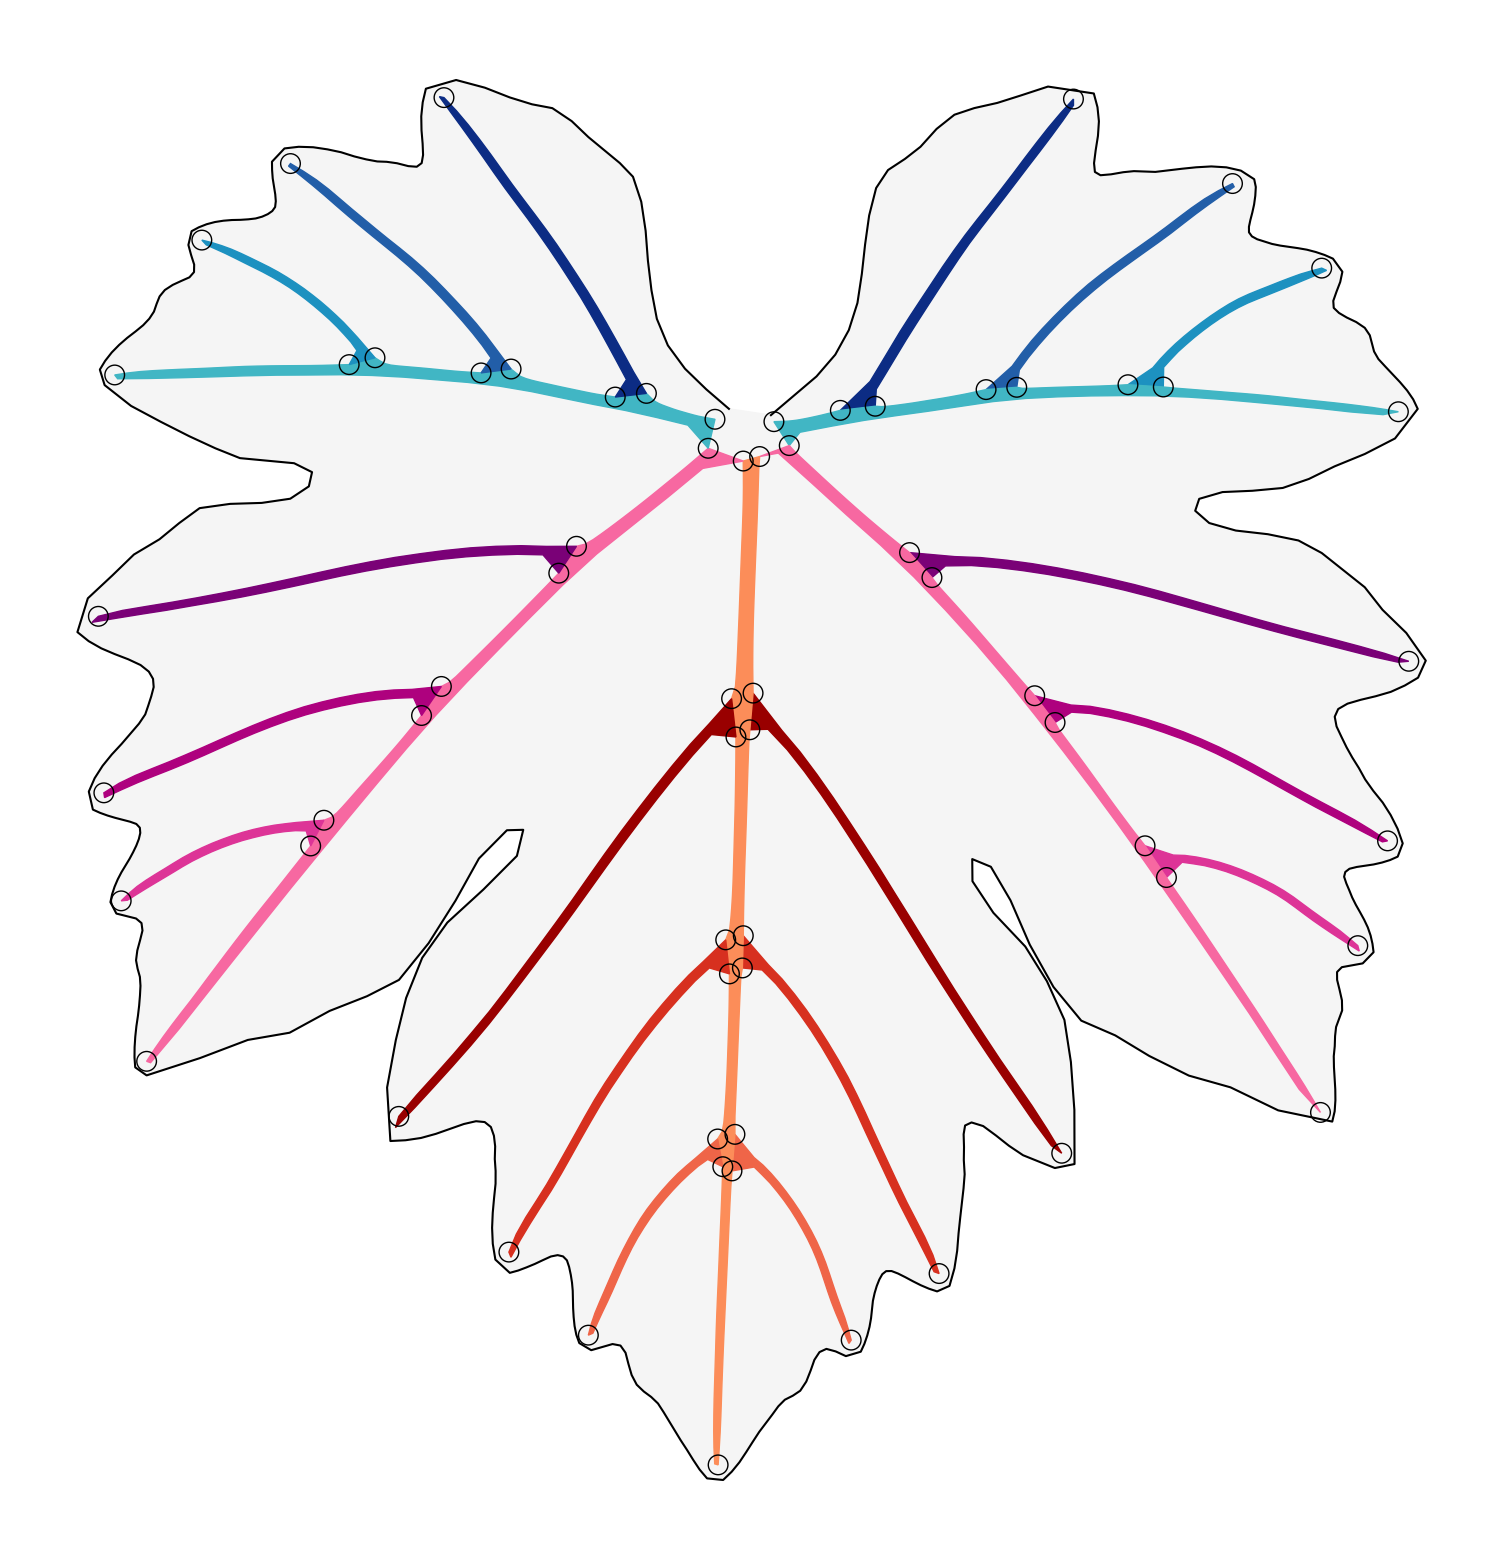

In [13]:
#################################
# plot the mean Procrustes leaf #
#################################

plt.figure(figsize=(20,20))

# blade outline
plt.plot(gpa_mean[num_vein_coords:,0],
         gpa_mean[num_vein_coords:,1], c="k")

# blade fill
plt.fill(gpa_mean[num_vein_coords:,0],
         gpa_mean[num_vein_coords:,1], c="whitesmoke")


plt.scatter(gpa_mean[vein_indices,0],
         gpa_mean[vein_indices,1],
           s=200, edgecolor="k", zorder=5, facecolor="none")

plt.fill(gpa_mean[lp1_indices,0],
         gpa_mean[lp1_indices,1], c=p1_col)

plt.fill(gpa_mean[lp2_indices,0],
         gpa_mean[lp2_indices,1], c=p2_col)

plt.fill(gpa_mean[lp3_indices,0],
         gpa_mean[lp3_indices,1], c=p3_col)

plt.fill(gpa_mean[lprox_indices,0],
         gpa_mean[lprox_indices,1], c=prox_col)

plt.fill(gpa_mean[ld1_indices,0],
         gpa_mean[ld1_indices,1], c=d1_col)

plt.fill(gpa_mean[ld2_indices,0],
         gpa_mean[ld2_indices,1], c=d2_col)

plt.fill(gpa_mean[ld3_indices,0],
         gpa_mean[ld3_indices,1], c=d3_col)

plt.fill(gpa_mean[ldist_indices,0],
         gpa_mean[ldist_indices,1], c=dist_col)

plt.fill(gpa_mean[lm1_indices,0],
         gpa_mean[lm1_indices,1], c=m1_col)

plt.fill(gpa_mean[lm2_indices,0],
         gpa_mean[lm2_indices,1], c=m2_col)

plt.fill(gpa_mean[lm3_indices,0],
         gpa_mean[lm3_indices,1], c=m3_col)

plt.fill(gpa_mean[mid_indices,0],
         gpa_mean[mid_indices,1], c=mid_col)

plt.fill(gpa_mean[rm3_indices,0],
         gpa_mean[rm3_indices,1], c=m3_col)

plt.fill(gpa_mean[rm2_indices,0],
         gpa_mean[rm2_indices,1], c=m2_col)

plt.fill(gpa_mean[rm1_indices,0],
         gpa_mean[rm1_indices,1], c=m1_col)

plt.fill(gpa_mean[rdist_indices,0],
         gpa_mean[rdist_indices,1], c=dist_col)

plt.fill(gpa_mean[rd3_indices,0],
         gpa_mean[rd3_indices,1], c=d3_col)

plt.fill(gpa_mean[rd2_indices,0],
         gpa_mean[rd2_indices,1], c=d2_col)

plt.fill(gpa_mean[rd1_indices,0],
         gpa_mean[rd1_indices,1], c=d1_col)

plt.fill(gpa_mean[rprox_indices,0],
         gpa_mean[rprox_indices,1], c=prox_col)

plt.fill(gpa_mean[rp3_indices,0],
         gpa_mean[rp3_indices,1], c=p3_col)

plt.fill(gpa_mean[rp2_indices,0],
         gpa_mean[rp2_indices,1], c=p2_col)

plt.fill(gpa_mean[rp1_indices,0],
         gpa_mean[rp1_indices,1], c=p1_col)

plt.gca().set_aspect("equal")
plt.axis("off")

#plt.savefig("./images/Fig01A_GPA_mean_leaf.png", bbox_inches='tight')

In [14]:
# an array to store procrustes aligned shapes
proc_arr = np.zeros((np.shape(shape_arr)[0],
                     np.shape(shape_arr)[1],
                     np.shape(shape_arr)[2]
                    ))
# for each leaf
for i in range(np.shape(shape_arr)[0]):

    # calculate superimposed shape to gpa_mean
    s1, s2, distance = procrustes(gpa_mean, shape_arr[i,:,:]) 
    
    # append procrustes shape to array
    proc_arr[i,:,:] = s2

# PRINCIPAL COMPONENT ANALYSIS

The PCA function from Scikit-learn (Pedregosa et al., 2011) was used for Principal Component Analysis (PCA). Eigenleaf representations were calculated using the inverse_transform function. 

#### Percent variance for all PCs

In [15]:
np.shape(proc_arr)

(71, 1672, 2)

In [16]:
len(algeria_name_list)

71

In [17]:
######
PC_NUMBER = 2 
#######

# use the reshape function to flatten proc_arr to 2D
reshaped_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                      np.shape(proc_arr)[1]*2) 

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(reshaped_arr) # fit a PCA

print(pca.explained_variance_ratio_) # print out explained variance for each PC
print(pca.explained_variance_ratio_.cumsum())


[0.32367767 0.12739563]
[0.32367767 0.4510733 ]


-0.13631828928363102
-0.10185365909017981


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_88614/70613982.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', 100) # set the color map


-0.0673890288967286
-0.03292439870327739
0.0015402314901738212
0.03600486168362502
0.07046949187707624
0.10493412207052746
0.13939875226397866
0.17386338245742985


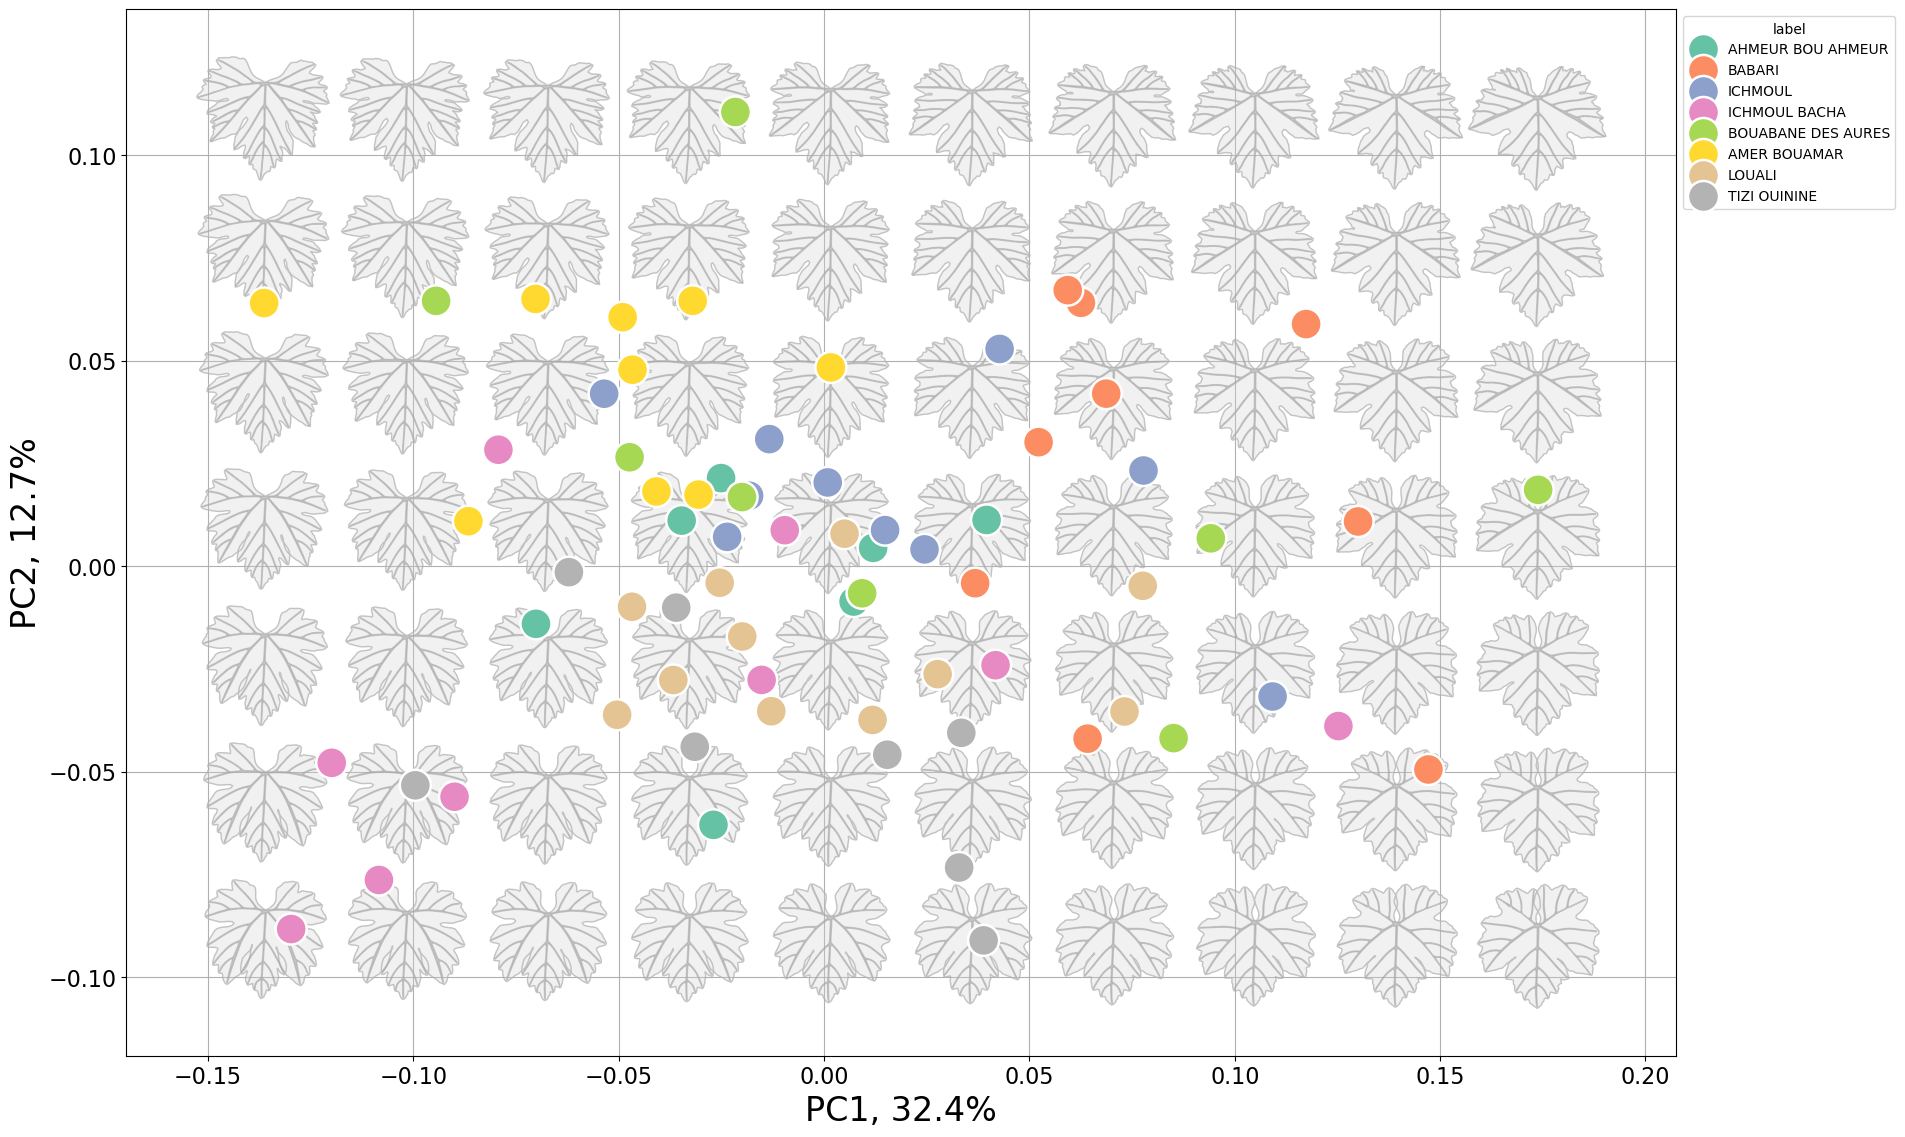

In [18]:
# Create dataframe for Algeria PCA

algeria_pca_df = pd.DataFrame({
    "PC1":PCs[:,0],
    "PC2":PCs[:,1],
    "label":algeria_name_list
})

# Create color palette for seaborn

label_pal = {
    'AHMEUR BOU AHMEUR':"#66c2a5",
    'BABARI':"#fc8d62",
    'ICHMOUL':"#8da0cb",
    'ICHMOUL BACHA':"#e78ac3",
    'BOUABANE DES AURES':"#a6d854",
    'AMER BOUAMAR':"#ffd92f",
    'LOUALI':"#e5c494",
    'TIZI OUININE':"#b3b3b3",
}

# Create PC values to reconstruct

numPC1 = 10 # set PC1 intervals
numPC2 = 7 # set PC2 intervals

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

# Visualize the morphospace

cmap = cm.get_cmap('plasma', 100) # set the color map
s = 0.45 # set the scale

plt.figure(figsize=(20,20))

for i in PC1_vals:
    
    print(i)
    
    for j in PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_leaf = np.reshape(inv_leaf, (1672,2))

        inv_leaf_veinX = inv_leaf[0:num_vein_coords,0]
        inv_leaf_veinY = inv_leaf[0:num_vein_coords,1]
        inv_leaf_bladeX = inv_leaf[num_vein_coords:,0]
        inv_leaf_bladeY = inv_leaf[num_vein_coords:,1]

        vein_area = PolyArea(inv_leaf_veinX,inv_leaf_veinY)
        leaf_area = PolyArea(inv_leaf_bladeX,inv_leaf_bladeY)
        blade_area = leaf_area-vein_area
        vtb_ratio = np.log(vein_area/blade_area)
        vtb_min = -4
        norm_vtb = vtb_ratio/vtb_min
        hexcol = matplotlib.colors.rgb2hex(cmap(norm_vtb))

        plt.fill(inv_leaf_bladeX*s+pc1_val, inv_leaf_bladeY*s+pc2_val, c="lightgray",alpha=0.3)
        plt.plot(inv_leaf_bladeX*s+pc1_val, inv_leaf_bladeY*s+pc2_val, c="darkgray", lw=1, alpha=0.6)
        plt.fill(inv_leaf_veinX*s+pc1_val, inv_leaf_veinY*s+pc2_val, c="darkgray",alpha=0.6)


ax=sns.scatterplot(data=algeria_pca_df, x="PC1", y="PC2", hue="label", palette=label_pal, zorder=2, s=500, alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#plt.xlim(xlim1,xlim2)
#plt.ylim(ylim1,ylim2)
         
xlab = "PC1, " + str(np.round(pca.explained_variance_ratio_[0],3)*100) + "%"
ylab = "PC2, " + str(np.round(pca.explained_variance_ratio_[1],3)*100) + "%"
plt.xlabel(xlab, fontsize=24)
plt.ylabel(ylab, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor("white")
plt.grid()
plt.gca().set_axisbelow(True)

# All leaves

In [7]:
# recode labels as vinifera, wild, rootstock, dissected

geno_labels = ["vinifera",#'ALICANTE BOUSCHET'
 "vinifera",#'CABERNET SAUVIGNON'
 "vinifera",#'CHARDONNAY'
 "dissected",#'CHASSELAS CIOUTAT'
 "vinifera",#'CHASSELAS DORÉ'
 "vinifera",#'FLAME TOKAY'
 "vinifera",#'GEWÜRTZTRAMINER'
 "vinifera",#'PINOT NOIR'
 "vinifera",#'SYLVANER'
 "vinifera",#'SYRAH'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS PALMATA'
 "dissected",#'VITIS PIASEZKII'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS THUNBERGII'
 "wild",#'VITIS VULPINA'
 "vinifera",#'WHITE RIESLING'
 "vinifera",#'ZINFANDEL'
 "wild",#'VITIS RUPESTRIS'
 "dissected",#'AMPELOPSIS ACONITIFOLIA'
 "wild",#'VITIS RUPESTRIS'
 "dissected",#'CHASSELAS CIOUTAT'
 "dissected",#'CHASSELAS CIOUTAT'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS THUNBERGII'
 "dissected",#'AMPELOPSIS GLANDULOSA'
 "dissected",#'AMPELOPSIS GLANDULOSA'
 "wild",#'VITIS VULPINA'
 "dissected",#'VITIS PIASEZKII'
 "dissected",#'AMPELOPSIS ACONITIFOLIA'
 "dissected",#'AMPELOPSIS GLANDULOSA'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RUPESTRIS'
 "dissected",#'AMPELOPSIS ACONITIFOLIA'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS CINEREA'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS RUPESTRIS'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS RIPARIA'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS LABRUSCA'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS ACERIFOLIA'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS AMURENSIS'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS VULPINA'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS AESTIVALIS'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS COIGNETIAE'
 "wild",#'VITIS PALMATA'
 "wild",#'VITIS PALMATA'
 "wild",#'VITIS PALMATA'
 "wild",#'VITIS PALMATA'
 "wild",#'VITIS ROMANETII'
 "wild",#'VITIS DOANIANA'
 "wild",#'VITIS ROMANETII'
 "wild",#'VITIS DOANIANA'
 "rootstock",#'5C'
 "rootstock",#'5C'
 "rootstock",#'DOG RIDGE'
 "rootstock",#'DOG RIDGE'
 "vinifera",#'CORVINA VERONSE'
 "vinifera",#'CORVINA VERONSE'
 "rootstock",#'AXR1'
 "rootstock",#'AXR1'
 "wild",#'VITIS ACERIFOLIA'
 "rootstock",#'O39-16'
 "rootstock",#'O39-16'
 "vinifera",#'CINSAULT'
 "vinifera",#'CINSAULT'
 "rootstock",#'GRN3'
 "vinifera",#'MERLOT'
 "vinifera",#'MALVASIA BIANCA'
 "rootstock",#'1613C'
 "vinifera",#'TREBBIANO'
 "vinifera",#'SYLVANER'
 "vinifera",#'BONARDA'
 "vinifera",#'BONARDA'
 "rootstock",#'RS-9'
 "rootstock",#'RS-9'
 "vinifera",#'CABERNET FRANC'
 "vinifera",#'VALDEPENAS'
 "vinifera",#'VALDEPENAS'
 "vinifera",#'VESPOLINA'
 "vinifera",#'FOLLE BLANCE'
 "vinifera",#'FOLLE BLANCE'
 "vinifera",#'PETIT VERDOT'
 "vinifera",#'PETIT VERDOT'
 "rootstock",#'DOG RIDGE'
 "rootstock",#'RAMSEY'
 "rootstock",#'RAMSEY'
 "vinifera",#'PARELLADA'
 "vinifera",#'PARELLADA'
 "rootstock",#'44-53M'
 "rootstock",#'44-53M'
 "rootstock",#'1103P'
 "vinifera",#'MUSCAT OTTONEL'
 "vinifera",#'MUSCAT OTTONEL'
 "vinifera",#'SIEGERREBE'
 "rootstock",#'5C'
 "rootstock",#'5C'
 "rootstock",#'5BB'
 "rootstock",#'5BB'
 "vinifera",#'TANNAT'
 "vinifera",#'ALICANTE BOUSCHET'
 "rootstock",#'8B'
 "rootstock",#'8B'
 "vinifera",#'EMERALD RIESLING'
 "wild",#'VITIS ARIZONICA'
 "wild",#'VITIS ARIZONICA'
 "rootstock",#'DOG RIDGE'
 "vinifera",#'BURGER'
# the remainder are all algeria
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
"algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
"algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
"algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",
 "algeria",


]

In [8]:
file_substrings = []
for i in range(len(scaled_vein_list)):
    file_substrings.append(leaf_list[index_list[i]])

file_substrings

['000_ALICANTEBOUSCHET',
 '000_CABERNETSAUVIGNON',
 '000_CHARDONNAY',
 '000_CHASSELASCIOUTAT',
 '000_CHASSELASDORE',
 '000_FLAMETOKAY',
 '000_GEWURTZTRAMINER',
 '000_PINOTNOIR',
 '000_SYLVANER',
 '000_SYRAH',
 '000_VITISACERIFOLIA',
 '000_VITISAESTIVALIS',
 '000_VITISAMURENSIS',
 '000_VITISCINEREA',
 '000_VITISCOIGNETIAE',
 '000_VITISLABRUSCA',
 '000_VITISPALMATA',
 '000_VITISPIASEZKII',
 '000_VITISRIPARIA',
 '000_VITISRUPESTRIS',
 '000_VITISTHUNBERGII',
 '000_VITISVULPINA',
 '000_WHITERIESLING',
 '000_ZINFANDEL',
 '001_leaf4_588147a',
 '002_leaf1_wGVIT1627a',
 '003_leaf5_588147a',
 '004_leafb_K1164A',
 '005_leafc_K1163A',
 '006_leaf2_483180a',
 '007_leaf8_w588055a',
 '008_leaf2_wGVIT1626a',
 '009_leaf10_wGVIT1626b',
 '010_leaf2_483186a',
 '011_leaf11_597257a',
 '013_leaf6_wGVIT1627a',
 '014_leaf3_588538a',
 '015_leaf1_279897a',
 '016_leaf9_588174a',
 '017_leaf9_wGVIT1627a',
 '018_leaf1_588154a',
 '019_leaf2_588154a',
 '020_leaf3_588154a',
 '021_leaf4_588154a',
 '022_leaf1_588174a',
 '

In [9]:
# create shape array

num_samples = len(scaled_vein_list)
num_vein_coords = np.shape(scaled_vein_list)[1]
num_blade_coords = np.shape(scaled_blade_list)[1]
num_pseuds = num_vein_coords + num_blade_coords
num_coords = 2

shape_arr = np.zeros((num_samples, num_pseuds, num_coords))

for i in range(len(scaled_vein_list)):
    
    shape_arr[i] = np.row_stack((scaled_vein_list[i], scaled_blade_list[i]))

np.shape(shape_arr)

(210, 1672, 2)

In [10]:
print("NUMBER OF VEIN COORDS", num_vein_coords)
print("NUMBER OF BLADE COORDS", num_blade_coords)

NUMBER OF VEIN COORDS 1216
NUMBER OF BLADE COORDS 456


In [11]:
# calculate GPA mean

gpa_mean = calc_gpa_mean(shape_arr, num_pseuds, num_coords)

In [12]:
# calculate indices of landmark points
# provide colors for fill

######################
# Individual indices #
######################

peta = 0

lp1a = 18
lp1t = lp1a+19
lp1b = lp1t+20

lp2a = lp1b+18
lp2t = lp2a+19
lp2b = lp2t+20

lp3a = lp2b+18
lp3t = lp3a+19
lp3b = lp3t+20

lptip = lp3b+18

###############

ldst = lptip+20

ld1a = ldst+18
ld1t = ld1a+19
ld1b = ld1t+20

ld2a = ld1b+18
ld2t = ld2a+19
ld2b = ld2t+20

ld3a = ld2b+18
ld3t = ld3a+19
ld3b = ld3t+20

ldtip = ld3b+18

###############

lmst = ldtip+20

lm1a = lmst+18
lm1t = lm1a+19
lm1b = lm1t+20

lm2a = lm1b+18
lm2t = lm2a+19
lm2b = lm2t+20

lm3a = lm2b+18
lm3t = lm3a+19
lm3b = lm3t+20

###############
mtip = lm3b+18
###############

rm3b = mtip+19
rm3t = rm3b+20
rm3a = rm3t+19

rm2b = rm3a+18
rm2t = rm2b+20
rm2a = rm2t+19

rm1b = rm2a+18
rm1t = rm1b+20
rm1a = rm1t+19

rmst = rm1a+18

###############

rdtip = rmst+20

rd3b = rdtip+18
rd3t = rd3b+20
rd3a = rd3t+19

rd2b = rd3a+18
rd2t = rd2b+20
rd2a = rd2t+19

rd1b = rd2a+18
rd1t = rd1b+20
rd1a = rd1t+19

rdst = rd1a+18

###############

rptip = rdst+20

rp3b = rptip+18
rp3t = rp3b+20
rp3a = rp3t+19

rp2b = rp3a+18
rp2t = rp2b+20
rp2a = rp2t+19

rp1b = rp2a+18
rp1t = rp1b+20
rp1a = rp1t+19

rpst = rp1a+18

####################
# Indices for fill #
####################

vein_indices = [
    peta, lp1a, lp1t, lp1b, lp2a, lp2t, lp2b, lp3a, lp3t, lp3b, lptip,
    ldst, ld1a, ld1t, ld1b, ld2a, ld2t, ld2b, ld3a, ld3t, ld3b, ldtip,
    lmst, lm1a, lm1t, lm1b, lm2a, lm2t, lm2b, lm3a, lm3t, lm3b, 
    mtip,
    rm3b, rm3t, rm3a, rm2b, rm2t, rm2a, rm1b, rm1t, rm1a, rmst,
    rdtip, rd3b, rd3t, rd3a, rd2b, rd2t, rd2a, rd1b, rd1t, rd1a, rdst,
    rptip, rp3b, rp3t, rp3a, rp2b, rp2t, rp2a, rp1b, rp1t, rp1a, rpst,
    ]

lp1_indices = list(range(lp1a,lp1b+1))
lp2_indices = list(range(lp2a,lp2b+1))
lp3_indices = list(range(lp3a,lp3b+1))
lprox_indices = list(range(peta,lp1a+1))+list(range(lp1b,lp2a+1))+list(range(lp2b,lp3a+1))+list(range(lp3b,ldst+1))

ld1_indices = list(range(ld1a,ld1b+1))
ld2_indices = list(range(ld2a,ld2b+1))
ld3_indices = list(range(ld3a,ld3b+1))
ldist_indices = list(range(ldst,ld1a+1))+list(range(ld1b,ld2a+1))+list(range(ld2b,ld3a+1))+list(range(ld3b,lmst+1))

lm1_indices = list(range(lm1a,lm1b+1))
lm2_indices = list(range(lm2a,lm2b+1))
lm3_indices = list(range(lm3a,lm3b+1))

mid_indices = list(range(lmst,lm1a+1))+list(range(lm1b,lm2a+1))+list(range(lm2b,lm3a+1))+list(range(lm3b,rm3b+1))+list(range(rm3a,rm2b+1))+list(range(rm2a,rm1b+1))+list(range(rm1a,rmst+1))

rm3_indices = list(range(rm3b,rm3a+1))
rm2_indices = list(range(rm2b,rm2a+1))
rm1_indices = list(range(rm1b,rm1a+1))

rdist_indices = list(range(rmst,rd3b+1))+list(range(rd3a,rd2b+1))+list(range(rd2a,rd1b+1))+list(range(rd1a,rdst+1))
rd3_indices = list(range(rd3b,rd3a+1))
rd2_indices = list(range(rd2b,rd2a+1))
rd1_indices = list(range(rd1b,rd1a+1))

rprox_indices = list(range(rdst,rp3b+1))+list(range(rp3a,rp2b+1))+list(range(rp2a,rp1b+1))+list(range(rp1a,rpst+1))
rp3_indices = list(range(rp3b,rp3a+1))
rp2_indices = list(range(rp2b,rp2a+1))
rp1_indices = list(range(rp1b,rp1a+1))

###################
# Colors for fill #
###################

m1_col = "#990000"
m2_col = "#d7301f"
m3_col = "#ef6548"
mid_col = "#fc8d59"

d1_col = "#7a0177"
d2_col = "#ae017e"
d3_col = "#dd3497"
dist_col = "#f768a1"

p1_col = "#0c2c84"
p2_col = "#225ea8"
p3_col = "#1d91c0"
prox_col = "#41b6c4"


(-0.03342515417970268,
 0.03346565859574244,
 -0.04186326572687127,
 0.030999871860018187)

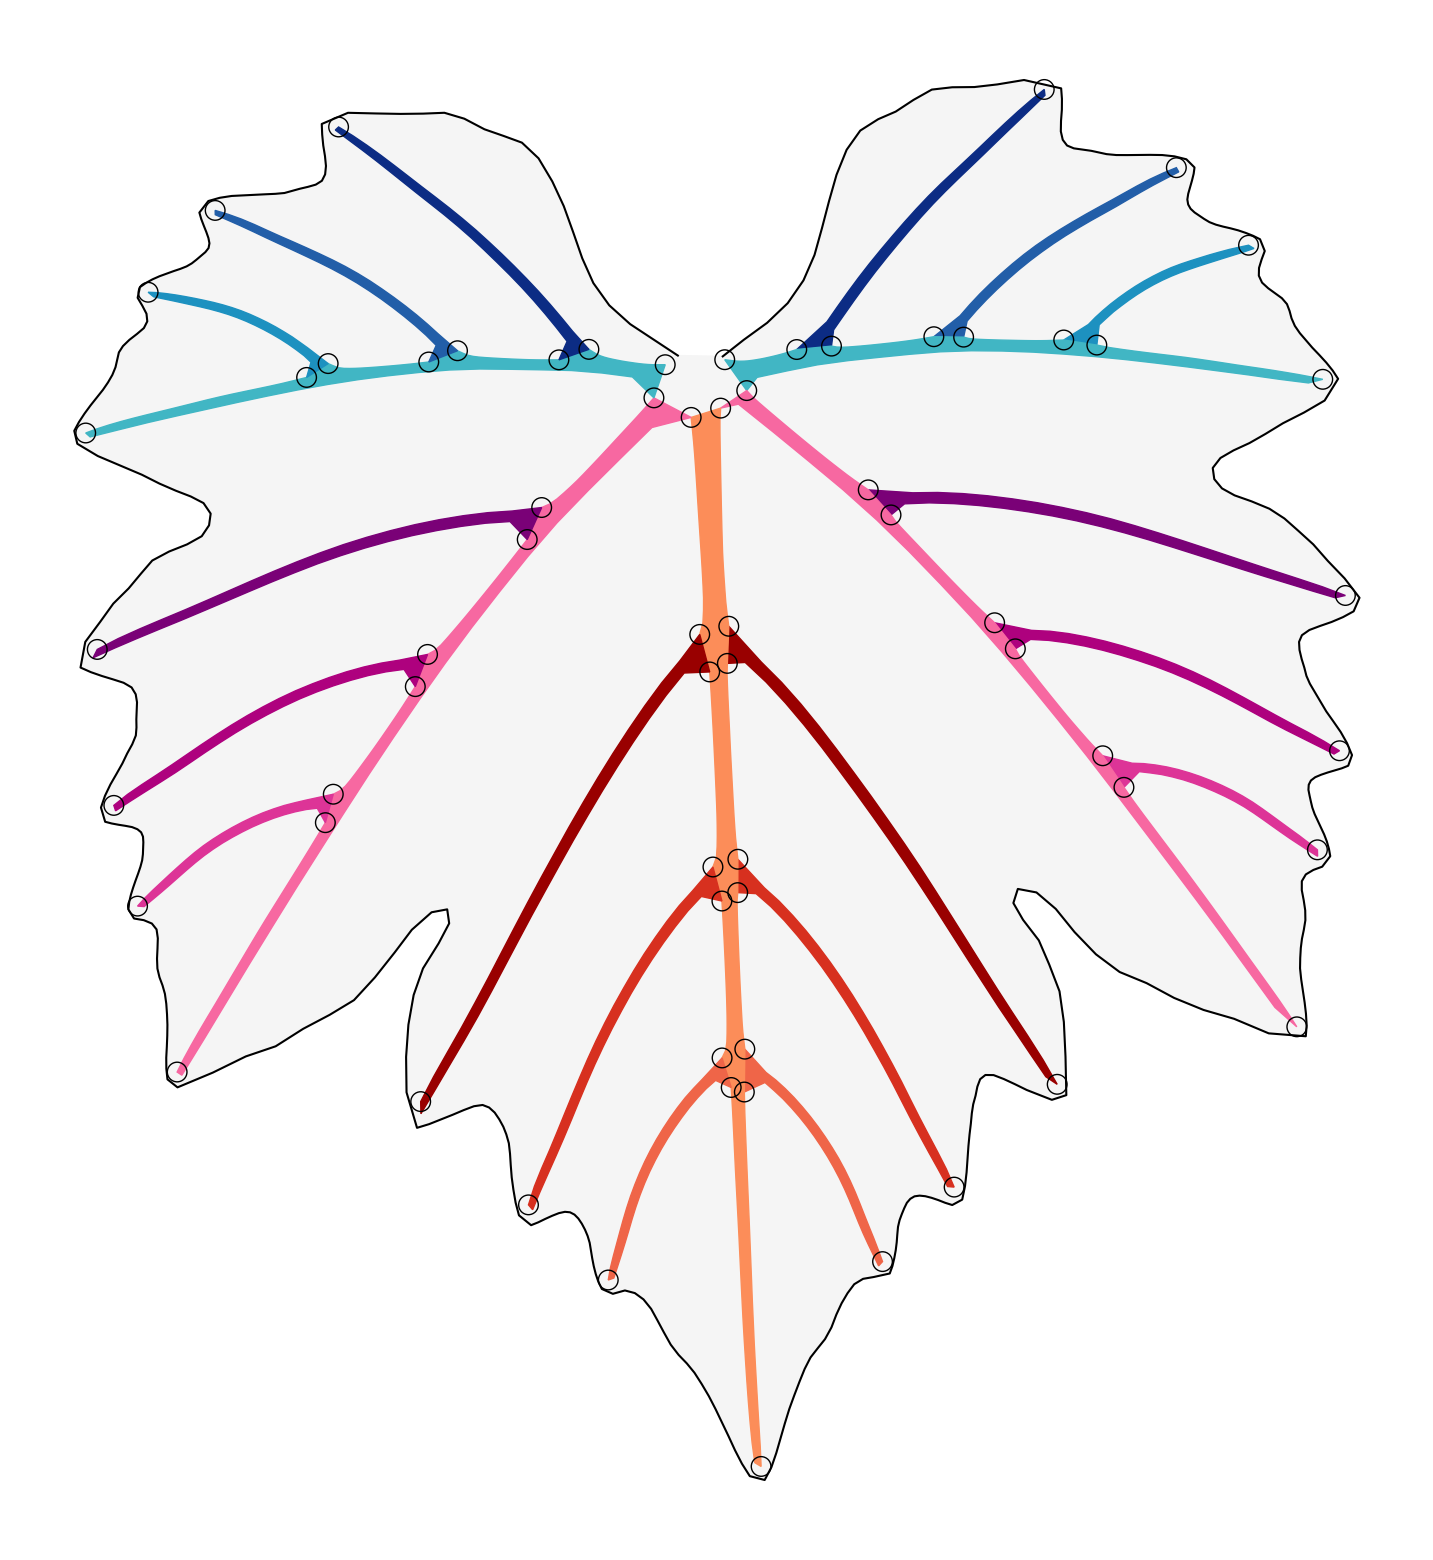

In [13]:
#################################
# plot the mean Procrustes leaf #
#################################

plt.figure(figsize=(20,20))

# blade outline
plt.plot(gpa_mean[num_vein_coords:,0],
         gpa_mean[num_vein_coords:,1], c="k")

# blade fill
plt.fill(gpa_mean[num_vein_coords:,0],
         gpa_mean[num_vein_coords:,1], c="whitesmoke")


plt.scatter(gpa_mean[vein_indices,0],
         gpa_mean[vein_indices,1],
           s=200, edgecolor="k", zorder=5, facecolor="none")

plt.fill(gpa_mean[lp1_indices,0],
         gpa_mean[lp1_indices,1], c=p1_col)

plt.fill(gpa_mean[lp2_indices,0],
         gpa_mean[lp2_indices,1], c=p2_col)

plt.fill(gpa_mean[lp3_indices,0],
         gpa_mean[lp3_indices,1], c=p3_col)

plt.fill(gpa_mean[lprox_indices,0],
         gpa_mean[lprox_indices,1], c=prox_col)

plt.fill(gpa_mean[ld1_indices,0],
         gpa_mean[ld1_indices,1], c=d1_col)

plt.fill(gpa_mean[ld2_indices,0],
         gpa_mean[ld2_indices,1], c=d2_col)

plt.fill(gpa_mean[ld3_indices,0],
         gpa_mean[ld3_indices,1], c=d3_col)

plt.fill(gpa_mean[ldist_indices,0],
         gpa_mean[ldist_indices,1], c=dist_col)

plt.fill(gpa_mean[lm1_indices,0],
         gpa_mean[lm1_indices,1], c=m1_col)

plt.fill(gpa_mean[lm2_indices,0],
         gpa_mean[lm2_indices,1], c=m2_col)

plt.fill(gpa_mean[lm3_indices,0],
         gpa_mean[lm3_indices,1], c=m3_col)

plt.fill(gpa_mean[mid_indices,0],
         gpa_mean[mid_indices,1], c=mid_col)

plt.fill(gpa_mean[rm3_indices,0],
         gpa_mean[rm3_indices,1], c=m3_col)

plt.fill(gpa_mean[rm2_indices,0],
         gpa_mean[rm2_indices,1], c=m2_col)

plt.fill(gpa_mean[rm1_indices,0],
         gpa_mean[rm1_indices,1], c=m1_col)

plt.fill(gpa_mean[rdist_indices,0],
         gpa_mean[rdist_indices,1], c=dist_col)

plt.fill(gpa_mean[rd3_indices,0],
         gpa_mean[rd3_indices,1], c=d3_col)

plt.fill(gpa_mean[rd2_indices,0],
         gpa_mean[rd2_indices,1], c=d2_col)

plt.fill(gpa_mean[rd1_indices,0],
         gpa_mean[rd1_indices,1], c=d1_col)

plt.fill(gpa_mean[rprox_indices,0],
         gpa_mean[rprox_indices,1], c=prox_col)

plt.fill(gpa_mean[rp3_indices,0],
         gpa_mean[rp3_indices,1], c=p3_col)

plt.fill(gpa_mean[rp2_indices,0],
         gpa_mean[rp2_indices,1], c=p2_col)

plt.fill(gpa_mean[rp1_indices,0],
         gpa_mean[rp1_indices,1], c=p1_col)

plt.gca().set_aspect("equal")
plt.axis("off")

#plt.savefig("./images/Fig01A_GPA_mean_leaf.png", bbox_inches='tight')

In [14]:
# an array to store procrustes aligned shapes
proc_arr = np.zeros((np.shape(shape_arr)[0],
                     np.shape(shape_arr)[1],
                     np.shape(shape_arr)[2]
                    ))
# for each leaf
for i in range(np.shape(shape_arr)[0]):

    # calculate superimposed shape to gpa_mean
    s1, s2, distance = procrustes(gpa_mean, shape_arr[i,:,:]) 
    
    # append procrustes shape to array
    proc_arr[i,:,:] = s2

In [15]:
######
PC_NUMBER = 2 
#######

# use the reshape function to flatten proc_arr to 2D
reshaped_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                      np.shape(proc_arr)[1]*2) 

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(reshaped_arr) # fit a PCA

print(pca.explained_variance_ratio_) # print out explained variance for each PC
print(pca.explained_variance_ratio_.cumsum())

[0.43795041 0.10711211]
[0.43795041 0.54506252]


In [16]:
geno_pca_df = pd.DataFrame({
    "PC1":PCs[:,0],
    "PC2":PCs[:,1],
    "label":geno_labels
})

label_pal = {"vinifera":"#7570b3", 
             "wild":"#fb6a4a",
             "error":"#e6ab02",
             "MSU":"#66c2a5",
             "UC Davis":"#a6d854",
             "leaf1":"#67000d",
             "leaf2":"#a50f15",
             "leaf3":"#cb181d",
             "leaf4":"#ef3b2c",
             "rootstock":"orange",
             "dissected":"gold",
             "algeria":"#97D700"
            }

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/1166452340.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', 100) # set the color map


-0.28566406091988933
-0.2185783622105839
-0.1514926635012785
-0.08440696479197307
-0.017321266082667652
0.04976443262663777
0.11685013133594319
0.1839358300452486
0.251021528754554
0.31810722746385944


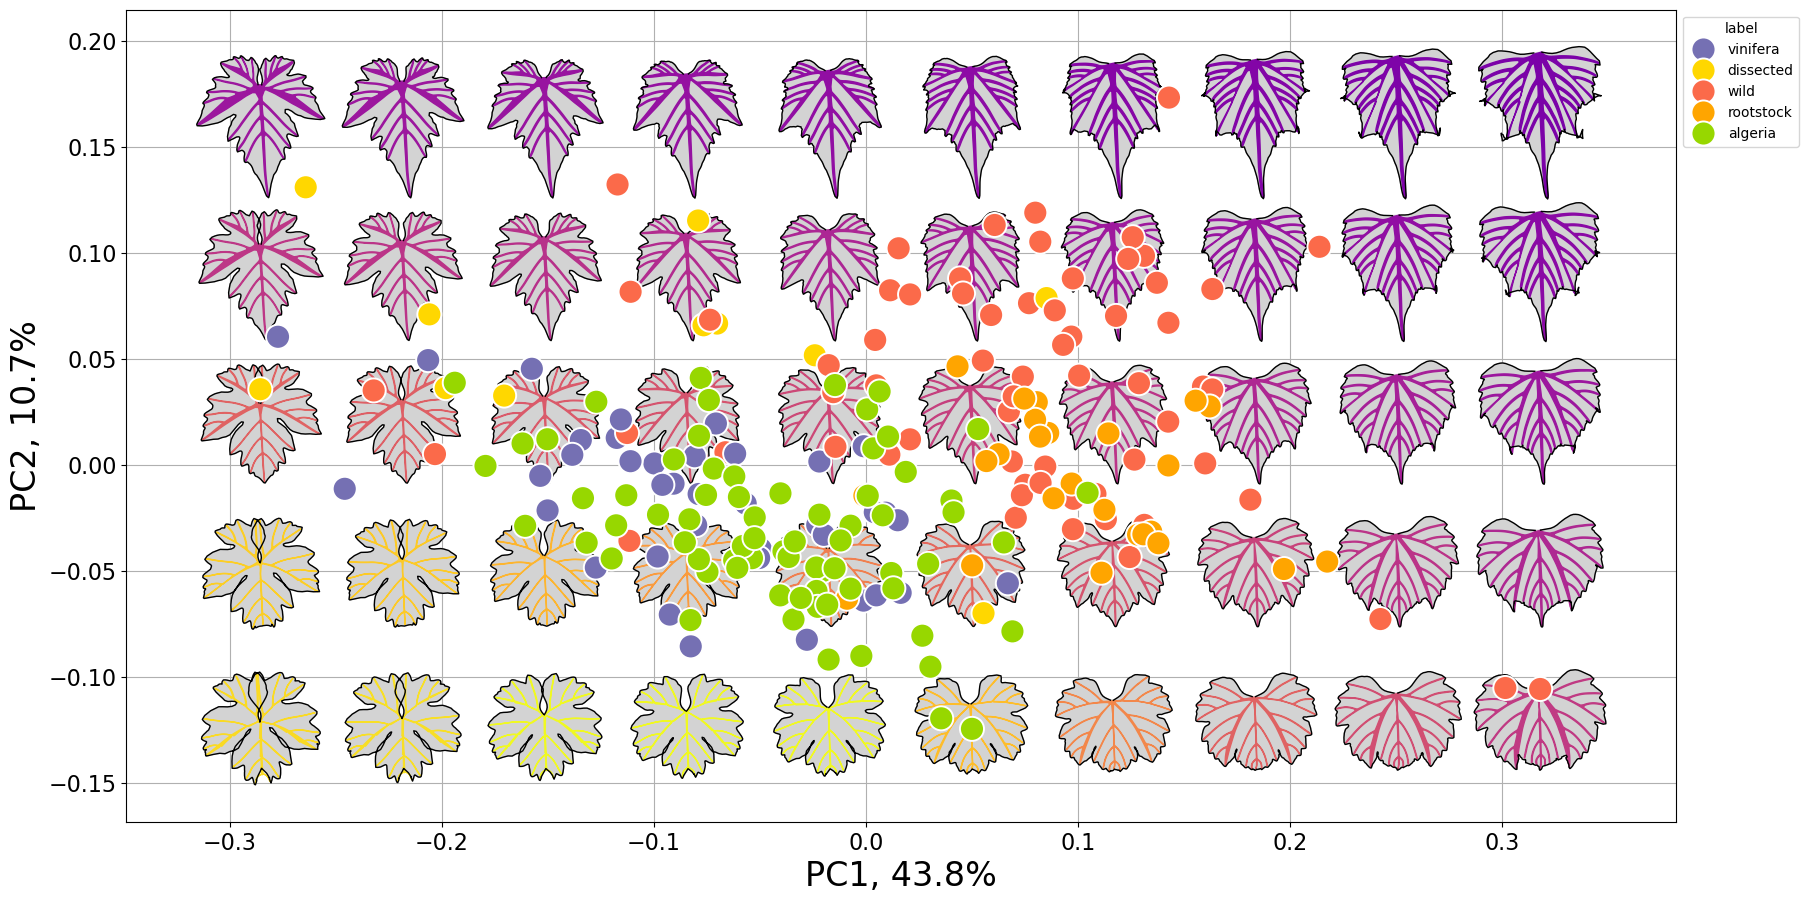

In [17]:
# Create PC values to reconstruct

numPC1 = 10 # set PC1 intervals
numPC2 = 5 # set PC2 intervals

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

# Visualize the morphospace

cmap = cm.get_cmap('plasma', 100) # set the color map
s = 0.8 # set the scale

plt.figure(figsize=(20,20))

for i in PC1_vals:
    
    print(i)
    
    for j in PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_leaf = np.reshape(inv_leaf, (1672,2))

        inv_leaf_veinX = inv_leaf[0:num_vein_coords,0]
        inv_leaf_veinY = inv_leaf[0:num_vein_coords,1]
        inv_leaf_bladeX = inv_leaf[num_vein_coords:,0]
        inv_leaf_bladeY = inv_leaf[num_vein_coords:,1]

        vein_area = PolyArea(inv_leaf_veinX,inv_leaf_veinY)
        leaf_area = PolyArea(inv_leaf_bladeX,inv_leaf_bladeY)
        blade_area = leaf_area-vein_area
        vtb_ratio = np.log(vein_area/blade_area)
        vtb_min = -4
        norm_vtb = vtb_ratio/vtb_min
        hexcol = matplotlib.colors.rgb2hex(cmap(norm_vtb))

        plt.fill(inv_leaf_bladeX*s+pc1_val, inv_leaf_bladeY*s+pc2_val, c="lightgray")
        plt.plot(inv_leaf_bladeX*s+pc1_val, inv_leaf_bladeY*s+pc2_val, c="k", lw=1)
        plt.fill(inv_leaf_veinX*s+pc1_val, inv_leaf_veinY*s+pc2_val, c=hexcol)


ax=sns.scatterplot(data=geno_pca_df, x="PC1", y="PC2", hue="label", palette=label_pal, zorder=2, s=300, alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#plt.xlim(xlim1,xlim2)
#plt.ylim(ylim1,ylim2)
         
xlab = "PC1, " + str(np.round(pca.explained_variance_ratio_[0],3)*100) + "%"
ylab = "PC2, " + str(np.round(pca.explained_variance_ratio_[1],3)*100) + "%"
plt.xlabel(xlab, fontsize=24)
plt.ylabel(ylab, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor("white")
plt.grid()
plt.gca().set_axisbelow(True)

#plt.savefig("./images/Fig04C_geno_morphospace.png", bbox_inches='tight')

# CREATE TRAINING DATA

## v7 training

In [22]:
import os
import numpy as np
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    r2_score, precision_recall_fscore_support, accuracy_score
)
from scipy.stats import pearsonr
from umap import UMAP
from sklearn.manifold import TSNE # NEW: Import t-SNE
import joblib
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ====================
# Device setup
# ====================
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================
# 1. Preprocessing Function (MODIFIED: Noise augmentation updated)
# ====================
def preprocess_leaf_masks(data_folder="data",
                          PCs=None,
                          names=None,
                          labels=None,
                          resolution=512,
                          n_rotations=20,
                          output_folder="PIXEL_IMAGES",
                          normalize_pcs=True,
                          blade_noise_prop_range=(0.0, 0.10), # MODIFIED: Changed to 0.10
                          vein_noise_prop_range=(0.0, 1.0),
                          blade_noise_num_clumps=(1, 5)):

    # Clear existing output folder to ensure a truly clean slate each time
    if os.path.exists(output_folder):
        print(f"Clearing existing output folder: {output_folder}...")
        shutil.rmtree(output_folder)
        print(f"Cleared {output_folder}.")

    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(os.path.join(output_folder, "MASKS"), exist_ok=True)
    os.makedirs(os.path.join(output_folder, "RGB_IMAGES"), exist_ok=True)

    assert PCs is not None and names is not None and labels is not None
    assert len(names) == len(PCs) == len(labels)

    all_filenames_raw = []
    all_labels_raw = []
    all_pcs_raw = []

    counter = 1

    for i, name in enumerate(names):
        label = labels[i]
        pc = PCs[i]

        blade_candidates = [f for f in os.listdir(data_folder) if name in f and "blade" in f]
        if not blade_candidates:
            print(f"ERROR: No blade file found for '{name}' in '{data_folder}'. Skipping this sample.")
            continue
        blade_file = blade_candidates[0]

        vein_candidates = [f for f in os.listdir(data_folder) if name in f and "veins" in f]
        if not vein_candidates:
            print(f"ERROR: No vein file found for '{name}' in '{data_folder}'. Skipping this sample.")
            continue
        vein_file = vein_candidates[0]

        blade = np.loadtxt(os.path.join(data_folder, blade_file))
        vein = np.loadtxt(os.path.join(data_folder, vein_file))
        all_coords_original = np.vstack([blade, vein]) # Keep original for centroid calculation

        # Calculate centroid once per leaf, before rotations
        leaf_centroid = all_coords_original.mean(axis=0)

        for rot in range(n_rotations):
            angle_deg = random.uniform(0, 360)
            angle_rad = np.deg2rad(angle_deg)
            R = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                          [np.sin(angle_rad),  np.cos(angle_rad)]])

            # Apply rotation around centroid
            rotated = (all_coords_original - leaf_centroid) @ R.T + leaf_centroid # Rotate around original centroid

            min_xy = rotated.min(axis=0)
            max_xy = rotated.max(axis=0)
            scale = resolution * 0.9 / max(max_xy - min_xy)
            scaled = (rotated - min_xy) * scale
            offset = (resolution - (max_xy - min_xy) * scale) / 2
            final_coords = scaled + offset

            n_blade = len(blade)
            blade_scaled = final_coords[:n_blade]
            vein_scaled = final_coords[n_blade:]

            mask = Image.new("L", (resolution, resolution), 0)
            draw = ImageDraw.Draw(mask)
            draw.polygon(blade_scaled.flatten().tolist(), fill=1) # Blade
            draw.polygon(vein_scaled.flatten().tolist(), fill=2)  # Vein

            # Convert mask to numpy array for pixel manipulation
            mask_np = np.array(mask)

            # --- Apply Noise ---
            # 1. Vein pixel removal (replace with blade) with Gaussian probability
            vein_pixels_coords = np.argwhere(mask_np == 2)
            if len(vein_pixels_coords) > 0:
                prop_to_remove_vein = random.uniform(*vein_noise_prop_range)
                num_to_remove_vein = int(prop_to_remove_vein * len(vein_pixels_coords))

                if num_to_remove_vein > 0:
                    # Calculate distances from centroid for vein pixels in image coordinates
                    # Scaled centroid: Re-calculate based on current rotation's scaled coordinates
                    current_scaled_centroid = (leaf_centroid - min_xy) * scale + offset

                    vein_distances = np.linalg.norm(vein_pixels_coords - current_scaled_centroid.round().astype(int), axis=1)

                    if vein_distances.max() > 0:
                        removal_probabilities = vein_distances / vein_distances.max() # Higher distance = higher prob
                    else:
                        removal_probabilities = np.zeros_like(vein_distances)

                    # Select pixels to remove based on these probabilities
                    # Sort indices by their removal probability in descending order and pick the top ones.
                    sorted_indices = np.argsort(removal_probabilities)[::-1]
                    indices_to_remove_actual = sorted_indices[:num_to_remove_vein]

                    for idx_in_list in indices_to_remove_actual:
                        r, c = vein_pixels_coords[idx_in_list]
                        mask_np[r, c] = 1 # MODIFIED: Replace vein (2) with blade (1)


            # 2. Blade pixel removal (clumped, replace with background)
            blade_pixels_coords = np.argwhere(mask_np == 1)
            if len(blade_pixels_coords) > 0:
                prop_to_remove_blade = random.uniform(*blade_noise_prop_range)
                num_to_remove_blade = int(prop_to_remove_blade * len(blade_pixels_coords))

                if num_to_remove_blade > 0:
                    num_clumps = random.randint(*blade_noise_num_clumps)
                    
                    # Ensure we have enough blade pixels to form distinct clumps
                    if len(blade_pixels_coords) < num_clumps:
                         num_clumps = len(blade_pixels_coords) # Limit clumps to available pixels

                    # Randomly select clump centers (seeds) from existing blade pixels
                    clump_centers_indices = random.sample(range(len(blade_pixels_coords)), num_clumps)
                    clump_centers = blade_pixels_coords[clump_centers_indices]

                    removed_pixels_count = 0
                    pixels_to_remove_set = set() # Use a set to avoid duplicates

                    # Iteratively remove pixels around centers until target count is met
                    # Or, more robustly, calculate a probability for each pixel based on distance to nearest clump center
                    
                    # Calculate distance of each blade pixel to its nearest clump center
                    min_distances = np.full(len(blade_pixels_coords), np.inf)
                    for center in clump_centers:
                        distances_to_center = np.linalg.norm(blade_pixels_coords - center, axis=1)
                        min_distances = np.minimum(min_distances, distances_to_center)

                    # Normalize distances (0 = furthest from any clump center, 1 = closest)
                    # We want to remove pixels *closest* to the clump centers, so invert the probability
                    if min_distances.max() > 0:
                        removal_probabilities = 1 - (min_distances / min_distances.max())
                    else:
                        removal_probabilities = np.zeros_like(min_distances)

                    # Select pixels based on these probabilities
                    sorted_indices = np.argsort(removal_probabilities)[::-1] # Sort descending (highest prob first)
                    
                    for idx_in_list in sorted_indices:
                        if removed_pixels_count >= num_to_remove_blade:
                            break
                        r, c = blade_pixels_coords[idx_in_list]
                        # Check if it's still a blade pixel (hasn't been removed by another clump)
                        if mask_np[r,c] == 1:
                            mask_np[r, c] = 0 # Set to background
                            removed_pixels_count += 1
            # --- End Apply Noise ---

            # Convert back to PIL Image and save
            mask = Image.fromarray(mask_np)
            mask_name = f"{label}_{counter:04d}.png"
            mask.save(os.path.join(output_folder, "MASKS", mask_name))

            rgb = Image.new("RGB", (resolution, resolution), (0, 0, 0))
            # Re-draw based on potentially modified mask_np for accurate visualization
            for r in range(resolution):
                for c in range(resolution):
                    if mask_np[r,c] == 1:
                        rgb.putpixel((c,r), (255, 140, 0)) # Blade orange
                    elif mask_np[r,c] == 2: # Veins (if any remained after removal/replacement)
                        rgb.putpixel((c,r), (255, 0, 255)) # Vein magenta
            rgb.save(os.path.join(output_folder, "RGB_IMAGES", mask_name))


            all_pcs_raw.append(pc)
            all_labels_raw.append(label)
            all_filenames_raw.append(mask_name)

            counter += 1

    metadata_df = pd.DataFrame({
        "filename": all_filenames_raw,
        "label": all_labels_raw,
        "PC1": [p[0] for p in all_pcs_raw],
        "PC2": [p[1] for p in all_pcs_raw]
    })

    if normalize_pcs:
        print("Normalizing PC values...")
        scaler = StandardScaler()
        metadata_df[['PC1', 'PC2']] = scaler.fit_transform(metadata_df[['PC1', 'PC2']])
        joblib.dump(scaler, os.path.join(output_folder, "pc_scaler.pkl"))
        print("PC values normalized and scaler saved.")

    metadata_df.to_csv(os.path.join(output_folder, "METADATA.csv"), index=False)

    print(f"Saved {len(metadata_df)} rotated leaf masks and metadata to '{output_folder}'.")


# ====================
# 2. Dataset class (NO CHANGE HERE)
# ====================
class LeafDataset(Dataset):
    def __init__(self, image_dir, metadata_file, transform=None):
        self.image_dir = image_dir
        self.metadata_df = pd.read_csv(metadata_file)
        self.transform = transform

        self.filenames = self.metadata_df['filename'].values
        self.label_encoder = LabelEncoder()
        # Use fit_transform on all labels from the metadata to ensure consistent mapping
        self.labels = self.label_encoder.fit_transform(self.metadata_df['label'])
        self.pcs = self.metadata_df[["PC1", "PC2"]].values.astype(np.float32)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.filenames[idx])
        image = Image.open(img_path).convert("L")

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        pcs = torch.tensor(self.pcs[idx], dtype=torch.float32)

        return image, label, pcs, self.filenames[idx]


# ====================
# 3. CNN model (MODIFIED: Dropout in embedding and regressor head)
# ====================
class CNNMultitask(nn.Module):
    def __init__(self, n_classes, resolution=512):
        super(CNNMultitask, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()

        self.flattened_size = 128 * (resolution // 16) * (resolution // 16)

        self.fc_embedding = nn.Linear(self.flattened_size, 256)
        self.dropout_embedding = nn.Dropout(0.4) # MODIFIED: Increased dropout

        # Regressor Head (added dropout)
        self.regressor_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2), # NEW: Added dropout
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

        # Classifier Head (deepened with dropout)
        self.classifier_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), # Kept at 0.3 as this was already doing well
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)

        if x.shape[1] != self.flattened_size:
            raise ValueError(f"Flattened feature size mismatch. Expected {self.flattened_size}, got {x.shape[1]}. "
                             "Please ensure your input image resolution is compatible with the CNN layers, "
                             "e.g., 512 for this model, or adjust CNN layers/use AdaptiveAvgPool2d.")

        embeddings = self.dropout_embedding(F.relu(self.fc_embedding(x)))

        pred_pcs = self.regressor_head(embeddings)
        pred_labels = self.classifier_head(embeddings)

        return pred_pcs, pred_labels, embeddings


# ====================
# 4. Training Function (MODIFIED: Early stopping patience)
# ====================
def train_model(data_dir="PIXEL_IMAGES",
                batch_size=16,
                lr=3e-4,
                epochs=150,
                alpha=0.3,
                eval_interval=5):

    metadata_file = os.path.join(data_dir, "METADATA.csv")
    image_dir = os.path.join(data_dir, "MASKS")

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_dataset = LeafDataset(image_dir, metadata_file, transform)

    original_labels = full_dataset.metadata_df['label'].values
    label_encoder_for_weights = LabelEncoder()
    encoded_labels = label_encoder_for_weights.fit_transform(original_labels)

    n_classes = len(np.unique(encoded_labels))

    class_counts = pd.Series(encoded_labels).value_counts().sort_index()
    total_samples = len(encoded_labels)

    # Ensure all classes from 0 to n_classes-1 are present in class_counts for correct indexing
    all_classes_counts = pd.Series(0, index=range(n_classes))
    all_classes_counts.update(class_counts)

    # Inverse frequency class weights
    class_weights = total_samples / (n_classes * (all_classes_counts.values + 1e-6))
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(f"Calculated class weights (Inverse Frequency): {class_weights}")


    train_indices, val_indices = train_test_split(
        range(len(full_dataset)), test_size=0.2, random_state=42,
        stratify=full_dataset.labels
    )
    train_loader = DataLoader(torch.utils.data.Subset(full_dataset, train_indices), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(torch.utils.data.Subset(full_dataset, val_indices), batch_size=batch_size)

    model = CNNMultitask(n_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion_reg = nn.MSELoss()
    criterion_cls = nn.CrossEntropyLoss(weight=class_weights)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

    print(f"\nStarting training for {epochs} epochs...")
    print(f"  Training samples: {len(train_indices)}")
    print(f"  Validation samples: {len(val_indices)}")
    print(f"  Number of classes: {n_classes}")
    print(f"  Initial Learning Rate: {lr}")
    print(f"  Alpha (Classification Loss Weight): {alpha}")


    train_losses = []
    val_losses = []

    # Early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 25 # MODIFIED: Increased patience

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_reg_loss = 0
        total_cls_loss = 0

        for batch_idx, (imgs, labels, pcs, filenames) in enumerate(train_loader):
            imgs, labels, pcs = imgs.to(device), labels.to(device), pcs.to(device)

            optimizer.zero_grad()

            pred_pcs, pred_labels, _ = model(imgs)

            loss_reg = criterion_reg(pred_pcs, pcs)
            loss_cls = criterion_cls(pred_labels, labels)

            loss = loss_reg + alpha * loss_cls

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_reg_loss += loss_reg.item()
            total_cls_loss += loss_cls.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} (Reg: {total_reg_loss/len(train_loader):.4f}, Cls: {total_cls_loss/len(train_loader):.4f})")

        if (epoch + 1) % eval_interval == 0 or epoch == epochs - 1:
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for imgs, labels, pcs, filenames in val_loader:
                    imgs, labels, pcs = imgs.to(device), labels.to(device), pcs.to(device)
                    pred_pcs, pred_labels, _ = model(imgs)
                    loss = criterion_reg(pred_pcs, pcs) + alpha * criterion_cls(pred_labels, labels)
                    total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            print(f"  Validation Loss: {avg_val_loss:.4f}")

            scheduler.step(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                model_save_path = os.path.join(data_dir, "cnn_multitask_model.pt")
                torch.save(model.state_dict(), model_save_path)
                print(f"✅ Model saved to {model_save_path} (best validation loss so far)")
            else:
                epochs_no_improve += eval_interval
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered after {epoch + 1} epochs. Validation loss has not improved for {patience} epochs.")
                    break


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    val_epochs = [e for e in range(1, epochs + 1) if (e % eval_interval == 0 or e == epochs)]
    if len(val_epochs) > len(val_losses):
        val_epochs = val_epochs[:len(val_losses)]
    elif len(val_epochs) < len(val_losses):
        pass # Handle cases where val_epochs might be shorter due to early stopping

    plt.plot(val_epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, "training_validation_loss.png"))
    plt.close()

    return model, train_losses, val_losses


# ====================
# 5. Evaluation Function (MODIFIED: Added TSNE, combined outputs to CSV)
# ====================
def evaluate_model(data_dir="PIXEL_IMAGES", data_split='all'):
    image_dir = os.path.join(data_dir, "MASKS")
    metadata_csv = os.path.join(data_dir, "METADATA.csv")
    model_path = os.path.join(data_dir, "cnn_multitask_model.pt")
    output_dir = os.path.join(data_dir, f"CNN_EVAL_OUTPUTS_{data_split.upper()}")
    os.makedirs(output_dir, exist_ok=True)

    transform = transforms.Compose([transforms.ToTensor()])

    full_dataset = LeafDataset(image_dir, metadata_csv, transform)

    if data_split == 'validation':
        _, val_indices = train_test_split(
            range(len(full_dataset)), test_size=0.2, random_state=42,
            stratify=full_dataset.labels
        )
        dataset_to_evaluate = torch.utils.data.Subset(full_dataset, val_indices)
        eval_title_suffix = " (Validation Data)"
        # Get filenames for the subset
        filenames_to_evaluate = [full_dataset.filenames[i] for i in val_indices]
    else: # data_split == 'all'
        dataset_to_evaluate = full_dataset
        eval_title_suffix = ""
        filenames_to_evaluate = full_dataset.filenames

    dataloader = DataLoader(dataset_to_evaluate, batch_size=16, shuffle=False)

    model = CNNMultitask(n_classes=len(np.unique(full_dataset.labels))).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    scaler = None
    scaler_path = os.path.join(data_dir, "pc_scaler.pkl")
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        print("Loaded PC scaler for inverse transformation.")

    all_preds_pcs = []
    all_true_pcs = []
    all_preds_labels = []
    all_true_labels = []
    all_embeddings = []
    all_filenames_in_order = [] # Store filenames in order of prediction

    with torch.no_grad():
        for images, labels, pcs, filenames in dataloader:
            images = images.to(device)
            pcs = pcs.to(device)
            labels = labels.to(device)

            preds_pcs, preds_labels, embeddings = model(images)

            all_preds_pcs.append(preds_pcs.cpu().numpy())
            all_true_pcs.append(pcs.cpu().numpy())
            all_preds_labels.append(preds_labels.argmax(dim=1).cpu().numpy())
            all_true_labels.append(labels.cpu().numpy())
            all_embeddings.append(embeddings.cpu().numpy())
            all_filenames_in_order.extend(filenames) # Use this list for the DataFrame

    pred_pcs_norm = np.vstack(all_preds_pcs)
    true_pcs_norm = np.vstack(all_true_pcs)
    pred_labels = np.concatenate(all_preds_labels)
    true_labels = np.concatenate(all_true_labels)
    embeddings = np.vstack(all_embeddings)

    label_names = full_dataset.label_encoder.inverse_transform(np.unique(full_dataset.labels))
    num_classes = len(label_names)

    if scaler is not None:
        pred_pcs = scaler.inverse_transform(pred_pcs_norm)
        true_pcs = scaler.inverse_transform(true_pcs_norm)
        print("Inverse transformed PCs for plotting.")
    else:
        pred_pcs = pred_pcs_norm
        true_pcs = true_pcs_norm

    # --- Save Combined Predictions and True Values to CSV ---
    # Convert numerical labels back to original string names
    true_label_names = full_dataset.label_encoder.inverse_transform(true_labels)
    pred_label_names = full_dataset.label_encoder.inverse_transform(pred_labels)

    results_df = pd.DataFrame({
        'filename': all_filenames_in_order,
        'true_label': true_label_names,
        'predicted_label': pred_label_names,
        'true_PC1': true_pcs[:, 0],
        'true_PC2': true_pcs[:, 1],
        'predicted_PC1': pred_pcs[:, 0],
        'predicted_PC2': pred_pcs[:, 1]
    })
    results_csv_path = os.path.join(output_dir, "predictions_and_true_values.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"✅ True and predicted values saved to: {results_csv_path}")


    # --- Regression Metrics (R2 and Pearsonr) ---
    r2_pc1 = r2_score(true_pcs[:, 0], pred_pcs[:, 0])
    r2_pc2 = r2_score(true_pcs[:, 1], pred_pcs[:, 1])
    pearson_pc1, _ = pearsonr(true_pcs[:, 0], pred_pcs[:, 0])
    pearson_pc2, _ = pearsonr(true_pcs[:, 1], pred_pcs[:, 1])

    # --- Classification Metrics ---
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None, labels=np.arange(num_classes))
    # Calculate weighted averages
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', labels=np.arange(num_classes))


    # --- Save Metrics to File ---
    metrics_file_path = os.path.join(output_dir, "metrics.txt")
    with open(metrics_file_path, 'w') as f:
        f.write(f"--- Evaluation Metrics {eval_title_suffix} ---\n\n")
        f.write(f"REGRESSION METRICS:\n")
        f.write(f"  R2 Score (PC1): {r2_pc1:.4f}\n")
        f.write(f"  Pearson Correlation (PC1): {pearson_pc1:.4f}\n")
        f.write(f"  R2 Score (PC2): {r2_pc2:.4f}\n")
        f.write(f"  Pearson Correlation (PC2): {pearson_pc2:.4f}\n\n")

        f.write(f"CLASSIFICATION METRICS:\n")
        f.write(f"  Overall Accuracy: {accuracy:.4f}\n\n")
        f.write(f"  Per-Class Metrics:\n")
        for i, class_name in enumerate(label_names):
            f.write(f"    Class '{class_name}':\n")
            f.write(f"      Precision: {precision[i]:.4f}\n")
            f.write(f"      Recall: {recall[i]:.4f}\n")
            f.write(f"      F1-Score: {f1[i]:.4f}\n")
        f.write(f"\n  Weighted Average Metrics:\n")
        f.write(f"    Precision (weighted): {weighted_precision:.4f}\n")
        f.write(f"    Recall (weighted): {weighted_recall:.4f}\n")
        f.write(f"    F1-Score (weighted): {weighted_f1:.4f}\n")
    print(f"✅ Metrics saved to: {metrics_file_path}")


    # --- Print to console as well ---
    print(f"\n--- Regression Metrics {eval_title_suffix} ---")
    print(f"R2 Score (PC1): {r2_pc1:.4f}")
    print(f"Pearson Correlation (PC1): {pearson_pc1:.4f}")
    print(f"R2 Score (PC2): {r2_pc2:.4f}")
    print(f"Pearson Correlation (PC2): {pearson_pc2:.4f}")

    print(f"\n--- Classification Metrics {eval_title_suffix} ---")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"\nPer-Class Metrics:")
    for i, class_name in enumerate(label_names):
        print(f"  Class '{class_name}': Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-Score={f1[i]:.4f}")
    print(f"\nWeighted Average Metrics:")
    print(f"  Precision (weighted): {weighted_precision:.4f}")
    print(f"  Recall (weighted): {weighted_recall:.4f}")
    print(f"  F1-Score (weighted): {weighted_f1:.4f}")


    # --- Save PC scatter (PC1 vs PC2) ---
    plt.figure(figsize=(8, 8))
    plt.scatter(true_pcs[:, 0], true_pcs[:, 1], label="True PCs", alpha=0.6, s=50, edgecolors='w')
    plt.scatter(pred_pcs[:, 0], pred_pcs[:, 1], label="Predicted PCs", alpha=0.6, s=50, edgecolors='w', marker='x')
    plt.title(f"True vs. Predicted PC Values{eval_title_suffix}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.savefig(os.path.join(output_dir, "pc_scatter_plot.png"))
    plt.close()

    # --- Save Individual PC Scatter Plots ---
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(true_pcs[:, 0], pred_pcs[:, 0], alpha=0.6, s=50, edgecolors='w')
    plt.title(f"True vs. Predicted PC1{eval_title_suffix}")
    plt.xlabel("True PC1")
    plt.ylabel("Predicted PC1")
    min_val = min(true_pcs[:, 0].min(), pred_pcs[:, 0].min())
    max_val = max(true_pcs[:, 0].max(), pred_pcs[:, 0].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit') # Diagonal line
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(true_pcs[:, 1], pred_pcs[:, 1], alpha=0.6, s=50, edgecolors='w')
    plt.title(f"True vs. Predicted PC2{eval_title_suffix}")
    plt.xlabel("True PC2")
    plt.ylabel("Predicted PC2")
    min_val = min(true_pcs[:, 1].min(), pred_pcs[:, 1].min())
    max_val = max(true_pcs[:, 1].max(), pred_pcs[:, 1].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit') # Diagonal line
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "individual_pc_scatter_plots.png"))
    plt.close()


    # --- Confusion Matrix ---
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix{eval_title_suffix}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    plt.close()

    # --- UMAP of Embeddings (Colored by True Labels) ---
    reducer_umap = UMAP(random_state=42)
    embeddings_2d_umap = reducer_umap.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    # Use different colors for each class in a categorical way
    for i, class_name in enumerate(label_names):
        indices = np.where(true_labels == i)
        plt.scatter(embeddings_2d_umap[indices, 0], embeddings_2d_umap[indices, 1],
                    label=class_name, s=20, alpha=0.7)
    plt.title(f"UMAP of Embeddings (True Labels){eval_title_suffix}")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="True Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "umap_true_labels.png"))
    plt.close()

    # --- UMAP of Embeddings (Colored by Predicted Labels) ---
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(label_names):
        indices = np.where(pred_labels == i)
        plt.scatter(embeddings_2d_umap[indices, 0], embeddings_2d_umap[indices, 1],
                    label=class_name, s=20, alpha=0.7)
    plt.title(f"UMAP of Embeddings (Predicted Labels){eval_title_suffix}")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Predicted Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "umap_pred_labels.png"))
    plt.close()

    # --- t-SNE of Embeddings (Colored by True Labels) --- NEW
    # Note: t-SNE can be computationally intensive for very large datasets
    # If it's too slow, we might sample a subset or just use UMAP.
    print(f"Generating t-SNE plot for {len(embeddings)} embeddings. This may take some time...")
    try:
        reducer_tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        embeddings_2d_tsne = reducer_tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 8))
        for i, class_name in enumerate(label_names):
            indices = np.where(true_labels == i)
            plt.scatter(embeddings_2d_tsne[indices, 0], embeddings_2d_tsne[indices, 1],
                        label=class_name, s=20, alpha=0.7)
        plt.title(f"t-SNE of Embeddings (True Labels){eval_title_suffix}")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.legend(title="True Label", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "tsne_true_labels.png"))
        plt.close()
        print(f"✅ t-SNE plot for True Labels saved to: {os.path.join(output_dir, 'tsne_true_labels.png')}")

        # --- t-SNE of Embeddings (Colored by Predicted Labels) --- NEW
        plt.figure(figsize=(10, 8))
        for i, class_name in enumerate(label_names):
            indices = np.where(pred_labels == i)
            plt.scatter(embeddings_2d_tsne[indices, 0], embeddings_2d_tsne[indices, 1],
                        label=class_name, s=20, alpha=0.7)
        plt.title(f"t-SNE of Embeddings (Predicted Labels){eval_title_suffix}")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.legend(title="Predicted Label", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "tsne_pred_labels.png"))
        plt.close()
        print(f"✅ t-SNE plot for Predicted Labels saved to: {os.path.join(output_dir, 'tsne_pred_labels.png')}")

    except Exception as e:
        print(f"⚠️ Warning: Could not generate t-SNE plots. Error: {e}")
        print("t-SNE can be sensitive to data size/distribution. Consider reducing 'perplexity' or 'n_iter' if issues persist.")


    print(f"✅ Evaluation results saved in: {output_dir}")


# ====================
# 6. Main Execution (FINAL CORRECTED LAYOUT - USES YOUR EXTERNAL DATA)
#    This block expects 'file_substrings', 'geno_labels', and 'PCs'
#    to be defined in previous cells of your Jupyter notebook.
# ====================
if __name__ == "__main__":
    # --- Configuration Parameters ---
    DATA_DIR = "PIXEL_IMAGES" # Your preprocessed data folder
    LEARNING_RATE = 2e-4  # MODIFIED: Lowered learning rate
    EPOCHS = 150
    ALPHA_CLASSIFICATION_WEIGHT = 0.4 # MODIFIED: Increased classification loss weight
    EVAL_INTERVAL = 5 # How often to evaluate on validation set during training
    N_ROTATIONS = 40 # Keep high for rotation invariance
    BLADE_NOISE_PROPORTION_RANGE = (0.0, 0.10) # MODIFIED: Slightly reduced blade noise range
    VEIN_NOISE_PROPORTION_RANGE = (0.0, 1.0)
    BLADE_NOISE_NUM_CLUMPS = (1, 5)

    # --- Step 1: Preprocessing ---
    print("\n--- Running preprocessing to generate PIXEL_IMAGES ---")
    try:
        # These variables (file_substrings, geno_labels, PCs) are expected
        # to be already defined in earlier cells of your Jupyter Notebook.
        # DO NOT define dummy variables here, as they will overwrite your actual data.

        preprocess_leaf_masks(data_folder="data",
                              PCs=PCs,
                              names=file_substrings,
                              labels=geno_labels,
                              resolution=512,
                              n_rotations=N_ROTATIONS,
                              output_folder=DATA_DIR,
                              blade_noise_prop_range=BLADE_NOISE_PROPORTION_RANGE,
                              vein_noise_prop_range=VEIN_NOISE_PROPORTION_RANGE,
                              blade_noise_num_clumps=BLADE_NOISE_NUM_CLUMPS)
        print("--- PIXEL_IMAGES generated successfully ---")

    except NameError as e:
        print(f"\nERROR: Preprocessing aborted. A required variable (e.g., PCs, file_substrings, geno_labels) is not defined: {e}")
        print("Please ensure your preceding Jupyter Notebook cells that generate these variables have been executed.")
        exit()
    except FileNotFoundError as e:
        print(f"\nERROR: Data files not found for preprocessing: {e}")
        print("Please ensure your 'data' folder exists and contains the necessary 'blade' and 'veins' .txt files,")
        print("and that the `file_substrings` provided match their prefixes.")
        print("Exiting script because preprocessing failed.")
        exit()
    except Exception as e:
        print(f"\nAn unexpected error occurred during preprocessing: {e}")
        print("Please check your data loading and preprocess_leaf_masks parameters.")
        print("Exiting script because preprocessing failed.")
        exit()


    # --- Step 2: Train the model ---
    print("\n--- Starting Model Training ---")
    model, train_losses, val_losses = train_model(
        data_dir=DATA_DIR,
        lr=LEARNING_RATE,
        epochs=EPOCHS,
        alpha=ALPHA_CLASSIFICATION_WEIGHT,
        eval_interval=EVAL_INTERVAL
    )
    print("--- Model Training Finished ---")

    # --- Step 3: Evaluate the model ---
    print("\n--- Starting Model Evaluation (All Data) ---")
    evaluate_model(data_dir=DATA_DIR, data_split='all')
    print("--- Model Evaluation (All Data) Finished ---")

    print("\n--- Starting Model Evaluation (Validation Data) ---")
    evaluate_model(data_dir=DATA_DIR, data_split='validation')
    print("--- Model Evaluation (Validation Data) Finished ---")

Using device: mps

--- Running preprocessing to generate PIXEL_IMAGES ---
Normalizing PC values...
PC values normalized and scaler saved.
Saved 8400 rotated leaf masks and metadata to 'PIXEL_IMAGES'.
--- PIXEL_IMAGES generated successfully ---

--- Starting Model Training ---
Calculated class weights (Inverse Frequency): tensor([0.5915, 3.8182, 1.6800, 1.1053, 0.6462], device='mps:0')

Starting training for 150 epochs...
  Training samples: 6720
  Validation samples: 1680
  Number of classes: 5
  Initial Learning Rate: 0.0002
  Alpha (Classification Loss Weight): 0.4


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/150 | Train Loss: 1.4314 (Reg: 0.8341, Cls: 1.4934)
Epoch 2/150 | Train Loss: 1.1064 (Reg: 0.6586, Cls: 1.1194)
Epoch 3/150 | Train Loss: 0.9784 (Reg: 0.5916, Cls: 0.9672)
Epoch 4/150 | Train Loss: 0.9439 (Reg: 0.5653, Cls: 0.9464)
Epoch 5/150 | Train Loss: 0.8899 (Reg: 0.5285, Cls: 0.9035)
  Validation Loss: 1.7178
✅ Model saved to PIXEL_IMAGES/cnn_multitask_model.pt (best validation loss so far)
Epoch 6/150 | Train Loss: 0.8530 (Reg: 0.5154, Cls: 0.8440)
Epoch 7/150 | Train Loss: 0.7964 (Reg: 0.4884, Cls: 0.7700)
Epoch 8/150 | Train Loss: 0.7819 (Reg: 0.4735, Cls: 0.7711)
Epoch 9/150 | Train Loss: 0.7516 (Reg: 0.4532, Cls: 0.7461)
Epoch 10/150 | Train Loss: 0.7364 (Reg: 0.4480, Cls: 0.7211)
  Validation Loss: 0.8246
✅ Model saved to PIXEL_IMAGES/cnn_multitask_model.pt (best validation loss so far)
Epoch 11/150 | Train Loss: 0.7156 (Reg: 0.4299, Cls: 0.7141)
Epoch 12/150 | Train Loss: 0.7039 (Reg: 0.4244, Cls: 0.6988)
Epoch 13/150 | Train Loss: 0.6787 (Reg: 0.4046, Cls: 0.6853

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/2199705647.py:502: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path

Loaded PC scaler for inverse transformation.
Inverse transformed PCs for plotting.
✅ True and predicted values saved to: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_ALL/predictions_and_true_values.csv
✅ Metrics saved to: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_ALL/metrics.txt

--- Regression Metrics  ---
R2 Score (PC1): 0.6242
Pearson Correlation (PC1): 0.8776
R2 Score (PC2): 0.4880
Pearson Correlation (PC2): 0.8532

--- Classification Metrics  ---
Overall Accuracy: 0.8429

Per-Class Metrics:
  Class 'algeria': Precision=0.8986, Recall=0.7989, F1-Score=0.8459
  Class 'dissected': Precision=0.8632, Recall=0.9318, F1-Score=0.8962
  Class 'rootstock': Precision=0.7213, Recall=0.9110, F1-Score=0.8051
  Class 'vinifera': Precision=0.6985, Recall=0.8763, F1-Score=0.7774
  Class 'wild': Precision=0.9677, Recall=0.8300, F1-Score=0.8936

Weighted Average Metrics:
  Precision (weighted): 0.8608
  Recall (weighted): 0.8429
  F1-Score (weighted): 0.8460


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/2199705647.py:628: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pred_pcs[:, 0], pred_pcs[:, 1], label="Predicted PCs", alpha=0.6, s=50, edgecolors='w', marker='x')
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Generating t-SNE plot for 8400 embeddings. This may take some time...
✅ t-SNE plot for True Labels saved to: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_ALL/tsne_true_labels.png
✅ t-SNE plot for Predicted Labels saved to: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_ALL/tsne_pred_labels.png
✅ Evaluation results saved in: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_ALL
--- Model Evaluation (All Data) Finished ---

--- Starting Model Evaluation (Validation Data) ---


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/2199705647.py:502: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path

Loaded PC scaler for inverse transformation.
Inverse transformed PCs for plotting.
✅ True and predicted values saved to: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_VALIDATION/predictions_and_true_values.csv
✅ Metrics saved to: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_VALIDATION/metrics.txt

--- Regression Metrics  (Validation Data) ---
R2 Score (PC1): 0.5330
Pearson Correlation (PC1): 0.8111
R2 Score (PC2): 0.4192
Pearson Correlation (PC2): 0.7766

--- Classification Metrics  (Validation Data) ---
Overall Accuracy: 0.7625

Per-Class Metrics:
  Class 'algeria': Precision=0.8513, Recall=0.7359, F1-Score=0.7894
  Class 'dissected': Precision=0.7778, Recall=0.7955, F1-Score=0.7865
  Class 'rootstock': Precision=0.6036, Recall=0.8300, F1-Score=0.6989
  Class 'vinifera': Precision=0.5995, Recall=0.7730, F1-Score=0.6753
  Class 'wild': Precision=0.9074, Recall=0.7538, F1-Score=0.8235

Weighted Average Metrics:
  Precision (weighted): 0.7898
  Recall (weighted): 0.7625
  F1-Score (weighted): 0.7684


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_24143/2199705647.py:628: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pred_pcs[:, 0], pred_pcs[:, 1], label="Predicted PCs", alpha=0.6, s=50, edgecolors='w', marker='x')
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Generating t-SNE plot for 1680 embeddings. This may take some time...
✅ t-SNE plot for True Labels saved to: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_VALIDATION/tsne_true_labels.png
✅ t-SNE plot for Predicted Labels saved to: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_VALIDATION/tsne_pred_labels.png
✅ Evaluation results saved in: PIXEL_IMAGES/CNN_EVAL_OUTPUTS_VALIDATION
--- Model Evaluation (Validation Data) Finished ---


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>